The original codes are available on https://github.com/shibuiwilliam/audio_classification_keras

# ESC-50 audio classification

This notebook is an example of audio classification using convolutional neural network.
<br>
The data used is [ESC-50](https://github.com/karoldvl/ESC-50), which consists of 50 classes of environmental audio dataset.<br>
One data is in .wav format with 5 seconds each, total of 2,000 files.

In [27]:
import sys
print(sys.version)
print(sys.path)

3.9.7 (default, Sep 24 2021, 00:36:19) 
[Clang 12.0.0 (clang-1200.0.32.29)]
['/Volumes/lspc/research/ec2/ec2/Revised_audio_classification_CNN_ESC-50-master', '/Users/shihoakaki/.pyenv/versions/3.9.7/lib/python39.zip', '/Users/shihoakaki/.pyenv/versions/3.9.7/lib/python3.9', '/Users/shihoakaki/.pyenv/versions/3.9.7/lib/python3.9/lib-dynload', '', '/Users/shihoakaki/.local/lib/python3.9/site-packages', '/Users/shihoakaki/.pyenv/versions/3.9.7/lib/python3.9/site-packages']


In [28]:
import os
# import random
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
# import seaborn as sn
from sklearn import model_selection
# from sklearn import preprocessing
import IPython.display as ipd
from tqdm import tqdm
from tensorflow.keras.utils import to_categorical

In [29]:
!pip install -r requirements.txt --quiet

In [87]:
from tensorflow.keras.layers import Add
from tensorflow.keras.models import Model

In [86]:
import keras
from keras.models import Model
from keras.layers import Input, Dense, Dropout, Activation
from keras.layers import Conv2D, GlobalAveragePooling2D
from keras.layers import BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model

## Preparation

In [32]:
# load a wave data
def load_wave_data(audio_dir, file_name):
    file_path = os.path.join(audio_dir, file_name)
    x, fs = librosa.load(file_path, sr=44100)
    return x,fs

In [33]:
# change wave data to mel-stft
def calculate_melsp(x, n_fft=1024, hop_length=128):
    stft = np.abs(librosa.stft(x, n_fft=n_fft, hop_length=hop_length))**2
    log_stft = librosa.power_to_db(stft)
    melsp = librosa.feature.melspectrogram(S=log_stft,n_mels=128)
    return melsp

In [34]:
# display wave in plots
def show_wave(x):
    plt.plot(x)
    plt.show()

In [35]:
# display wave in heatmap
def show_melsp(melsp, fs):
    librosa.display.specshow(melsp, sr=fs)
    plt.colorbar()
    plt.show()

In [36]:
# This values are necessary to create and reshape data arrays
freq = 128
time = 1723

### Data is available on https://www.kaggle.com/mmoreaux/environmental-sound-classification-50


In [37]:
#!wget "https://github.com/karoldvl/ESC-50/archive/master.zip"
#!unzip -qq master.zip
#!cd ESC-50-master

In [38]:
# define directories
#base_dir = "../input/environmental-sound-classification-50"
base_dir = ""
esc_dir = os.path.join(base_dir, "ESC-50-master")
meta_file = os.path.join(esc_dir, "meta/esc50.csv")
audio_dir = os.path.join(esc_dir, "audio/")

In [39]:
# load metadata
meta_data = pd.read_csv(meta_file)
meta_data

filename  fold  target        category  esc10  src_file take
0      1-100032-A-0.wav     1       0             dog   True    100032    A
1     1-100038-A-14.wav     1      14  chirping_birds  False    100038    A
2     1-100210-A-36.wav     1      36  vacuum_cleaner  False    100210    A
3     1-100210-B-36.wav     1      36  vacuum_cleaner  False    100210    B
4     1-101296-A-19.wav     1      19    thunderstorm  False    101296    A
...                 ...   ...     ...             ...    ...       ...  ...
1995   5-263831-B-6.wav     5       6             hen  False    263831    B
1996  5-263902-A-36.wav     5      36  vacuum_cleaner  False    263902    A
1997   5-51149-A-25.wav     5      25       footsteps  False     51149    A
1998    5-61635-A-8.wav     5       8           sheep  False     61635    A
1999     5-9032-A-0.wav     5       0             dog   True      9032    A

[2000 rows x 7 columns]

In [40]:
# get data size
data_size = meta_data.shape
print(data_size)

(2000, 7)


In [41]:
# arrange target label and its name
class_dict = {}
for i in range(data_size[0]):
    if meta_data.loc[i,"target"] not in class_dict.keys():
        class_dict[meta_data.loc[i,"target"]] = meta_data.loc[i,"category"]
class_pd = pd.DataFrame(list(class_dict.items()), columns=["labels","classes"])

## Hint:
It strongly recommended to use kaggle notebook to access data quickly and not mess with library issues.
The trained model with %20 validation data and %10 test data are available on 
https://www.kaggle.com/tubistaj/model-files and
https://www.kaggle.com/tubistaj/test-array.

If you prefer use them you can continue with section ***Evaluate model***.
Otherwise, of course you are free to go ahead

## Load dataset

wave size:(220500,)
melsp size:(128, 1723)
samping rate:44100


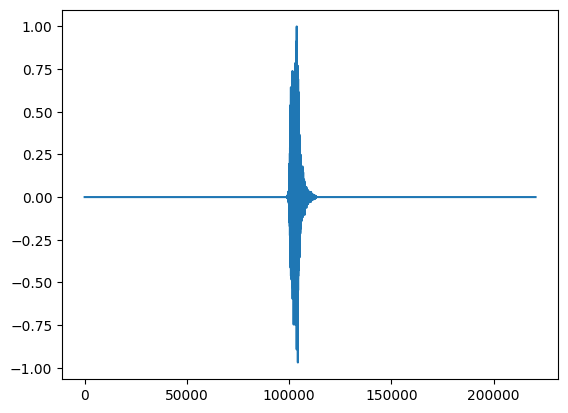

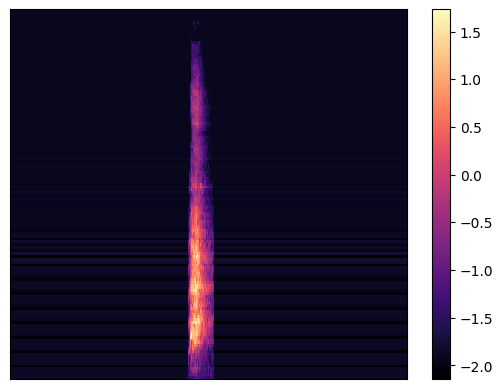

In [42]:
# example data
x, fs = load_wave_data(audio_dir, meta_data.loc[0,"filename"])
melsp = calculate_melsp(x)
print("wave size:{0}\nmelsp size:{1}\nsamping rate:{2}".format(x.shape, melsp.shape, fs))
show_wave(x)
show_melsp(melsp, fs)

In [43]:
ipd.Audio(x, rate=fs)

## Augment audio data

The augmented data available on https://www.kaggle.com/tubistaj/esc50aug, with using it you can pass this sections up to *Audio Classification with Deep Learning* section

The number of end of file names indicates the rate of splitting data in train and test. ie. esc_melsp_train_raw3.npz means %30 test rate.

However, if you do not want to use link you can go ahead.

In [44]:
# data augmentation: add white noise
def add_white_noise(x, rate=0.002):
    return x + rate*np.random.randn(len(x))

wave size:(220500,)
melsp size:(128, 1723)
samping rate:44100


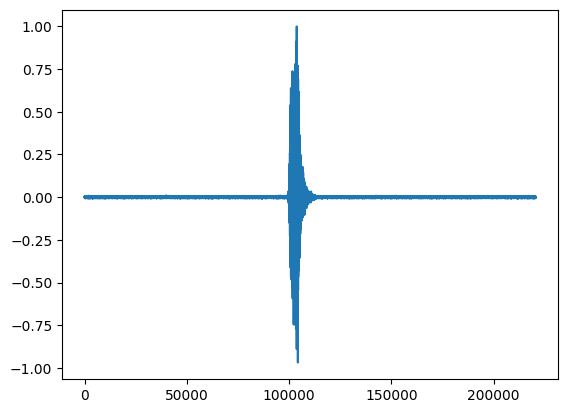

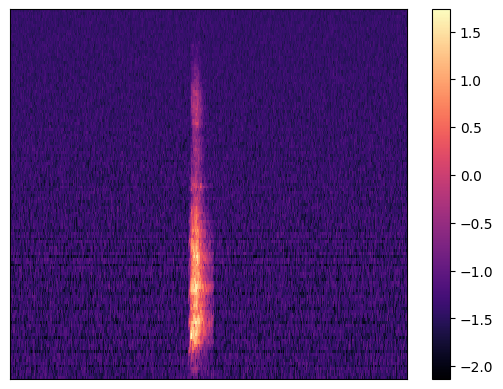

In [45]:
x_wn = add_white_noise(x)
melsp = calculate_melsp(x_wn)
print("wave size:{0}\nmelsp size:{1}\nsamping rate:{2}".format(x_wn.shape, melsp.shape, fs))
show_wave(x_wn)
show_melsp(melsp, fs)

In [46]:
ipd.Audio(x_wn, rate=fs)

In [47]:
# data augmentation: shift sound in timeframe
def shift_sound(x, rate=2):
    return np.roll(x, int(len(x)//rate))

wave size:(220500,)
melsp size:(128, 1723)
samping rate:44100


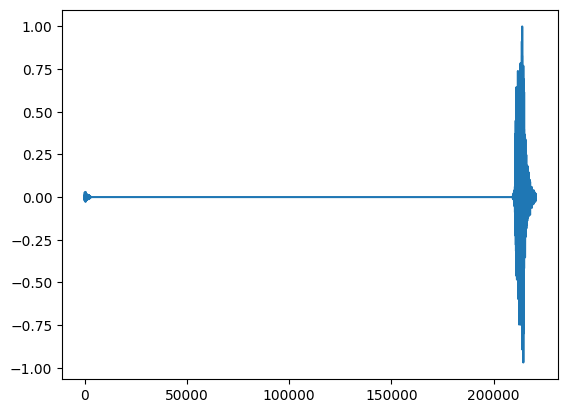

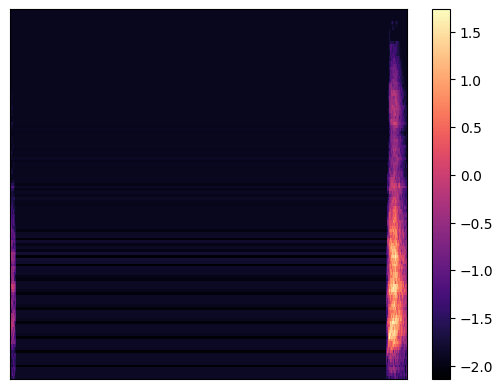

In [48]:
x_ss = shift_sound(x)
melsp = calculate_melsp(x_ss)
print("wave size:{0}\nmelsp size:{1}\nsamping rate:{2}".format(x_ss.shape, melsp.shape, fs))
show_wave(x_ss)
show_melsp(melsp, fs)

In [49]:
ipd.Audio(x_ss, rate=fs)

In [50]:
# data augmentation: stretch sound
def stretch_sound(x, rate=1.1):
    input_length = len(x)
    x = librosa.effects.time_stretch(x, rate=rate)
    if len(x)>input_length:
        return x[:input_length]
    else:
        return np.pad(x, (0, max(0, input_length - len(x))), "constant")

wave size:(220500,)
melsp size:(128, 1723)
samping rate:44100


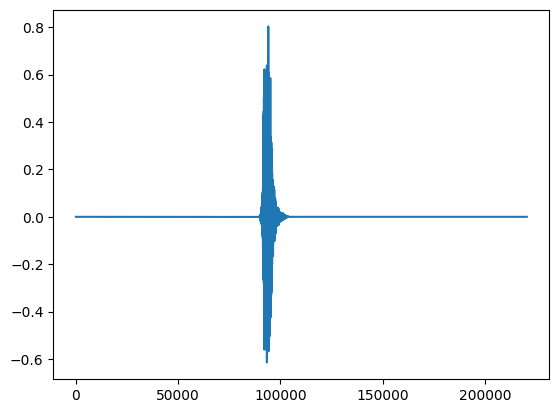

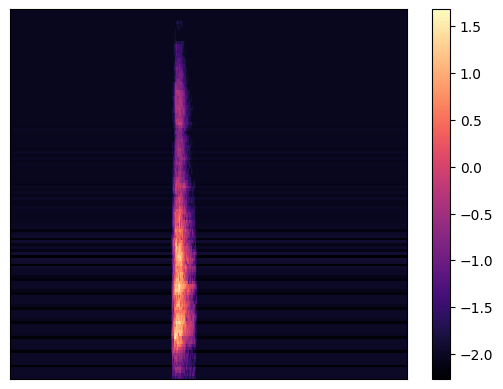

In [51]:
x_st = stretch_sound(x)
melsp = calculate_melsp(x_st)
print("wave size:{0}\nmelsp size:{1}\nsamping rate:{2}".format(x_st.shape, melsp.shape, fs))
show_wave(x_st)
show_melsp(melsp, fs)

In [52]:
ipd.Audio(x_st, rate=fs)

## Split training dataset and test dataset

In [53]:
# get training dataset and target dataset
x = list(meta_data.loc[:, "filename"])
y = list(meta_data.loc[:, "target"])

x_train, x_test, y_train, y_test = model_selection.train_test_split(x, y, test_size=0.25, stratify=y)
print("x train:{0}\ny train:{1}\nx test:{2}\ny test:{3}".format(len(x_train),
                                                                len(y_train), 
                                                                len(x_test), 
                                                                len(y_test)))

x train:1500
y train:1500
x test:500
y test:500


In [54]:
a = np.zeros(50)
for c in y_test:
    a[c] += 1
print(a)

[10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.]


## Transform wav data to mel-stft array 

Transform wav data files to mel-stft array, and save them as npz, separately with test, training and augmented training datasets.


In [55]:
# save wave data in npz, with augmentation
def save_np_data(filename, x, y, aug=None, rates=None):
    np_data = np.zeros(freq*time*len(x)).reshape(len(x), freq, time)
    np_targets = np.zeros(len(y))
    for i in range(len(y)):
        _x, fs = load_wave_data(audio_dir, x[i])
        if aug is not None:
            _x = aug(x=_x, rate=rates[i])
        _x = calculate_melsp(_x)
        np_data[i] = _x
        np_targets[i] = y[i]
    np.savez(filename, x=np_data, y=np_targets)  

In [56]:
# save test dataset
#if not os.path.exists("esc_melsp_test.npz"):
#    save_np_data("esc_melsp_test.npz", x_test,  y_test)

In [57]:
# save raw training dataset
#if not os.path.exists("esc_melsp_train_raw.npz"):
#    save_np_data("esc_melsp_train_raw.npz", x_train,  y_train)

In [58]:
# save training dataset with white noise
#if not os.path.exists("esc_melsp_train_wn.npz"):
#    rates = np.random.randint(1,50,len(x_train))/10000
#    save_np_data("esc_melsp_train_wn.npz", x_train,  y_train, aug=add_white_noise, rates=rates)

In [59]:
# save training dataset with sound shift
#if not os.path.exists("esc_melsp_train_ss.npz"):
#    rates = np.random.choice(np.arange(2,6),len(y_train))
#    save_np_data("esc_melsp_train_ss.npz", x_train,  y_train, aug=shift_sound, rates=rates)

In [60]:
# save training dataset with stretch
#if not os.path.exists("esc_melsp_train_st.npz"):
#    rates = np.random.choice(np.arange(80,120),len(y_train))/100
#    save_np_data("esc_melsp_train_st.npz", x_train,  y_train, aug=stretch_sound, rates=rates)

In [61]:
# save training dataset with combination of white noise and shift or stretch
"""
if not os.path.exists("esc_melsp_train_com.npz"):
    np_data = np.zeros(freq*time*len(x_train)).reshape(len(x_train), freq, time)
    np_targets = np.zeros(len(y_train))
    for i in range(len(y_train)):
        x, fs = load_wave_data(audio_dir, x_train[i])
        x = add_white_noise(x=x, rate=np.random.randint(1,50)/1000)
        if np.random.choice((True,False)):
            x = shift_sound(x=x, rate=np.random.choice(np.arange(2,6)))
        else:
            x = stretch_sound(x=x, rate=np.random.choice(np.arange(80,120))/100)
        x = calculate_melsp(x)
        np_data[i] = x
        np_targets[i] = y_train[i]
    np.savez("esc_melsp_train_com.npz", x=np_data, y=np_targets)
"""

'\nif not os.path.exists("esc_melsp_train_com.npz"):\n    np_data = np.zeros(freq*time*len(x_train)).reshape(len(x_train), freq, time)\n    np_targets = np.zeros(len(y_train))\n    for i in range(len(y_train)):\n        x, fs = load_wave_data(audio_dir, x_train[i])\n        x = add_white_noise(x=x, rate=np.random.randint(1,50)/1000)\n        if np.random.choice((True,False)):\n            x = shift_sound(x=x, rate=np.random.choice(np.arange(2,6)))\n        else:\n            x = stretch_sound(x=x, rate=np.random.choice(np.arange(80,120))/100)\n        x = calculate_melsp(x)\n        np_data[i] = x\n        np_targets[i] = y_train[i]\n    np.savez("esc_melsp_train_com.npz", x=np_data, y=np_targets)\n'

# Audio classification with deep learning


## Preparation for deep learning

In [62]:
# dataset files are available on https://www.kaggle.com/tubistaj/esc50aug 
files_dir = ''
train_files = [files_dir + "esc_melsp_train_raw.npz", 
               files_dir + "esc_melsp_train_ss.npz",
               files_dir + "esc_melsp_train_st.npz", 
               files_dir + "esc_melsp_train_wn.npz",
               files_dir + "esc_melsp_train_com.npz"]
test_file = files_dir + "esc_melsp_test.npz"

In [63]:
train_num = 1500 #1400?
test_num = 500  #600?

In [64]:
# load dataset
for i in tqdm(range(len(train_files))):
    data = np.load(train_files[i])
    x_train[i*train_num:(i+1)*train_num] = data["x"]
    y_train[i*train_num:(i+1)*train_num] = data["y"]

100%|██████████| 5/5 [01:30<00:00, 18.13s/it]


In [65]:
x_train = np.array(x_train)
x_test = np.array(x_test)

In [66]:
# load test dataset
test_data = np.load(test_file)
x_test = test_data["x"]
y_test = test_data["y"]

In [67]:
#!pip show keras
from tensorflow.keras import utils as np_utils


In [68]:
# redefine target data into one hot vector
classes = 50
y_train = np_utils.to_categorical(y_train, classes)
y_test = np_utils.to_categorical(y_test, classes)

In [69]:
# reshape training dataset
x_train = x_train.reshape(train_num*len(train_files), freq, time, 1) # 実行可能 1500
x_test = x_test.reshape(test_num, freq, time, 1) #600

In [70]:
# test data splitted to validation while learning and test in end of learning as %20 and %10
x_test, x_val, y_test, y_val= model_selection.train_test_split(x_test, y_test, test_size=2/3, random_state=1)

In [71]:

print("x train:{0}\ny train:{1}\nx val:{2}\ny val:{3}\nx test:{4}\ny test:{5}".format(x_train.shape,
                                                                                      y_train.shape,
                                                                                      x_val.shape,
                                                                                      y_val.shape,
                                                                                      x_test.shape, 
                                                                                      y_test.shape))

x train:(7500, 128, 1723, 1)
y train:(7500, 50)
x val:(334, 128, 1723, 1)
y val:(334, 50)
x test:(166, 128, 1723, 1)
y test:(166, 50)


## Define convolutional neural network

In [72]:
# これをDLして動かしたらうまくいったがその後コメントアウトしてもうまくいった
#from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, Input, Add, GlobalAveragePooling2D, Dense
#from tensorflow.keras.models import Model

In [73]:
def cba(x, filters, kernel_size, strides):
    #x = Conv2D(filters, kernel_size=kernel_size, strides=strides, padding='same')(inputs)
    x = Conv2D(filters, kernel_size, strides=strides, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

In [74]:
inputs = Input(shape=(x_train.shape[1:]))
type(inputs)

keras.src.backend.common.keras_tensor.KerasTensor

In [75]:
# define CNN
# CNNの定義


inputs = Input(shape=(x_train.shape[1:]))

x_1 = cba(inputs, filters=32, kernel_size=(1,8), strides=(1,2))
x_1 = cba(x_1, filters=32, kernel_size=(8,1), strides=(2,1))
x_1 = cba(x_1, filters=64, kernel_size=(1,8), strides=(1,2))
x_1 = cba(x_1, filters=64, kernel_size=(8,1), strides=(2,1))

x_2 = cba(inputs, filters=32, kernel_size=(1,16), strides=(1,2))
x_2 = cba(x_2, filters=32, kernel_size=(16,1), strides=(2,1))
x_2 = cba(x_2, filters=64, kernel_size=(1,16), strides=(1,2))
x_2 = cba(x_2, filters=64, kernel_size=(16,1), strides=(2,1))

x_3 = cba(inputs, filters=32, kernel_size=(1,32), strides=(1,2))
x_3 = cba(x_3, filters=32, kernel_size=(32,1), strides=(2,1))
x_3 = cba(x_3, filters=64, kernel_size=(1,32), strides=(1,2))
x_3 = cba(x_3, filters=64, kernel_size=(32,1), strides=(2,1))

x_4 = cba(inputs, filters=32, kernel_size=(1,64), strides=(1,2))
x_4 = cba(x_4, filters=32, kernel_size=(64,1), strides=(2,1))
x_4 = cba(x_4, filters=64, kernel_size=(1,64), strides=(1,2))
x_4 = cba(x_4, filters=64, kernel_size=(64,1), strides=(2,1))

x = Add()([x_1, x_2, x_3, x_4])

x = cba(x, filters=128, kernel_size=(1,16), strides=(1,2))
x = cba(x, filters=128, kernel_size=(16,1), strides=(2,1))

x = GlobalAveragePooling2D()(x)
x = Dense(classes)(x)
x = Activation("softmax")(x)

model = Model(inputs, x)
model.summary()



Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 1723, │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 862,  │        288 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 128, 862,  │        544 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 128, 862,  │      1,056 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 128, 862,  │      2,080 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128, 862,  │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 862,  │        128 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 862,  │        128 │ conv2d_8[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 862,  │        128 │ conv2d_12[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 128, 862,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 128, 862,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_8        │ (None, 128, 862,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_12       │ (None, 128, 862,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 64, 862,   │      8,224 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 862,   │     16,416 │ activation_4[0][… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 64, 862,   │     32,800 │ activation_8[0][… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 64, 862,   │     65,568 │ activation_12[0]

 Total params: 1,268,786 (4.84 MB)

 Trainable params: 1,266,738 (4.83 MB)

 Non-trainable params: 2,048 (8.00 KB)

## Optimization and callbacks

In [76]:
#!pip show keras
#!pip install keras --upgrade

In [77]:
from tensorflow.keras.optimizers import Adam

# Initialize the optimizer with the correct parameter names
opt = Adam(learning_rate=0.00005, decay=1e-6)  # Using 'lr' instead of 'learning_rate'

# Compile the model with the correctly initialized optimizer　: 生成したモデルに学習プロセスを設定
model.compile(
    loss='categorical_crossentropy',
    optimizer=opt,
    metrics=['acc']
)


/Users/shihoakaki/.pyenv/versions/3.9.7/lib/python3.9/site-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [78]:
# import
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint

In [81]:
import os
from keras.callbacks import EarlyStopping, Callback

# ディレクトリの作成
model_dir = "./models"
if not os.path.exists(model_dir):
    os.mkdir(model_dir)

# 早期終了の設定
es_cb = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')

# カスタムコールバックの作成
class CustomModelCheckpoint(Callback):
    def __init__(self, filepath):
        super(CustomModelCheckpoint, self).__init__()
        self.filepath = filepath

    def on_epoch_end(self, epoch, logs=None):
        filepath = self.filepath.format(epoch=epoch+1, val_loss=logs['val_loss'], val_acc=logs['val_acc'])
        self.model.save(filepath)
        print(f"Epoch {epoch+1}: saving model to {filepath}")

chkpt = os.path.join(model_dir, 'esc50_{epoch:02d}_{val_loss:.4f}_{val_acc:.4f}.hdf5')
cp_cb = CustomModelCheckpoint(filepath=chkpt)

# モデルのフィッティング　- しなくて
#model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=100, callbacks=[es_cb, cp_cb])


In [96]:
# directory for model checkpoints ↑で書き換えた
"""
model_dir = "./models"
if not os.path.exists(model_dir):
    os.mkdir(model_dir)

# early stopping and model checkpoints
# saves the model in each decreasing val_loss
es_cb = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')
chkpt = os.path.join(model_dir, 'esc50_.{epoch:02d}_{val_loss:.4f}_{val_acc:.4f}.hdf5')
cp_cb = ModelCheckpoint(filepath = chkpt, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
"""

'\nmodel_dir = "./models"\nif not os.path.exists(model_dir):\n    os.mkdir(model_dir)\n\n# early stopping and model checkpoints\n# saves the model in each decreasing val_loss\nes_cb = EarlyStopping(monitor=\'val_loss\', patience=10, verbose=1, mode=\'auto\')\nchkpt = os.path.join(model_dir, \'esc50_.{epoch:02d}_{val_loss:.4f}_{val_acc:.4f}.hdf5\')\ncp_cb = ModelCheckpoint(filepath = chkpt, monitor=\'val_loss\', verbose=1, save_best_only=True, mode=\'auto\')\n'

## Train CNN model with between class dataset

In [82]:
# between class data generator
class MixupGenerator():
    def __init__(self, x_train, y_train, batch_size=32, alpha=0.2, shuffle=True):
        self.x_train = x_train
        self.y_train = y_train
        self.batch_size = batch_size
        self.alpha = alpha
        self.shuffle = shuffle
        self.sample_num = len(x_train)

    def __call__(self):
        while True:
            indexes = self.__get_exploration_order()
            itr_num = int(len(indexes) // (self.batch_size * 2))

            for i in range(itr_num):
                batch_ids = indexes[i * self.batch_size * 2:(i + 1) * self.batch_size * 2]
                x, y = self.__data_generation(batch_ids)

                yield x, y

    def __get_exploration_order(self):
        indexes = np.arange(self.sample_num)

        if self.shuffle:
            np.random.shuffle(indexes)

        return indexes

    def __data_generation(self, batch_ids):
        _, h, w, c = self.x_train.shape
        _, class_num = self.y_train.shape
        x1 = self.x_train[batch_ids[:self.batch_size]]
        x2 = self.x_train[batch_ids[self.batch_size:]]
        y1 = self.y_train[batch_ids[:self.batch_size]]
        y2 = self.y_train[batch_ids[self.batch_size:]]
        l = np.random.beta(self.alpha, self.alpha, self.batch_size)
        x_l = l.reshape(self.batch_size, 1, 1, 1)
        y_l = l.reshape(self.batch_size, 1)

        x = x1 * x_l + x2 * (1 - x_l)
        y = y1 * y_l + y2 * (1 - y_l)

        return x, y

In [95]:
# train model
# 32 batch size takes 15 GB of RAM
# 60-32
batch_size = 1024
epochs = 2

training_generator = MixupGenerator(x_train, y_train)()
"""
model.fit_generator(generator=training_generator,
                    steps_per_epoch=x_train.shape[0] // batch_size,
                    validation_data=(x_val, y_val),
                    epochs=epochs, 
                    verbose=1,
                    callbacks=[es_cb, cp_cb],
                    shuffle=True)
"""
model.fit(
    x=training_generator,
    steps_per_epoch=x_train.shape[0] // batch_size,
    validation_data=(x_val, y_val),
    #validation_steps=len(val_generator),
    epochs=epochs,
    callbacks=[es_cb, cp_cb],
    shuffle=True,
) # 訓練の実行

Epoch 1/2
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 41s/step - acc: 0.0383 - loss: 3.8599 

Epoch 1: saving model to ./models/esc50_01_3.9068_0.0299.hdf5
7/7 ━━━━━━━━━━━━━━━━━━━━ 384s 56s/step - acc: 0.0386 - loss: 3.8555 - val_acc: 0.0299 - val_loss: 3.9068
Epoch 2/2
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 44s/step - acc: 0.0533 - loss: 3.8291 

Epoch 2: saving model to ./models/esc50_02_3.9080_0.0269.hdf5
7/7 ━━━━━━━━━━━━━━━━━━━━ 393s 59s/step - acc: 0.0545 - loss: 3.8253 - val_acc: 0.0269 - val_loss: 3.9080


## Evaluate model

If you use prepared model and test file uncomment the bottom section.

In [97]:
model = load_model("models/esc50_.46_0.7929_0.8050.hdf5")
#test_data = np.load("../input/test-array/test.npz") cannot find
#test_data = np.load("esc_melsp_test.npz")
#test_data = np.load("esc_melsp_train_ss.npz")
x_test = test_data["x"] # feature data
y_test = test_data["y"] # label data

/Users/shihoakaki/.pyenv/versions/3.9.7/lib/python3.9/site-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [100]:
#動かない
test_data = np.load("esc_melsp_train_raw.npz")
x_test = test_data["x"] # feature data
y_test = test_data["y"] # label data
evaluation = model.evaluate(x_test, y_test) # テストデータを与えて学習済みモデルを評価する
print(evaluation)

# 16/16 [==============================] - 4s 244ms/step - loss: 0.7291 - acc: 0.8320
# [0.7290524244308472, 0.8320000171661377]

# with test data
# 7/7 [==============================] - 2s 244ms/step - loss: 0.6410 - acc: 0.8500
# [0.6409585475921631, 0.8500000238418579]

ValueError: Arguments `target` and `output` must have the same rank (ndim). Received: target.shape=(None,), output.shape=(None, 50)

## Testing and sketching confusion matrix

In [118]:
from sklearn.metrics import accuracy_score, confusion_matrix
def conf_matrix(x_test, y_test, model, freq, time):
    y_pred = [] # 予測したラベル
    y_true = [] # 正解ラベル

    for i in tqdm(range(len(y_test))):
        true_label = np.argmax(y_test[i])  # ワンホットエンコードされたラベルのインデックスを取得
        y_true.append(true_label)

        preds = model.predict(x_test[i].reshape(1, freq, time, 1))  # サンプルデータを予測
        top_pred = np.argmax(preds)  # 最も高いスコアの予測を取得
        y_pred.append(top_pred)

    # 正確性の出力
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy}')

    # 混同行列の計算と出力
    #cm = confusion_matrix(y_true, y_pred) 
    cm = confusion_matrix(y_test, y_pred) #y_true, y_testの違いって何?どちらも正解ラベル？
    print(cm)
    return cm,y_true,y_pred

# 呼び出し例
cm,y_true,y_pred, = conf_matrix(x_test, y_test, model, freq, time)


# y_true:全て0, y_pred:予測されたラベル, y_true, y_test?

  0%|          | 0/1500 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 490ms/step


  0%|          | 1/1500 [00:00<14:24,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step


  0%|          | 2/1500 [00:00<11:24,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step


  0%|          | 3/1500 [00:01<10:12,  2.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


  0%|          | 4/1500 [00:01<09:02,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step


  0%|          | 5/1500 [00:01<08:34,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


  0%|          | 6/1500 [00:02<08:06,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


  0%|          | 7/1500 [00:02<07:51,  3.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


  1%|          | 8/1500 [00:02<07:47,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


  1%|          | 9/1500 [00:03<07:45,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step


  1%|          | 10/1500 [00:03<08:12,  3.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step


  1%|          | 11/1500 [00:03<08:20,  2.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step


  1%|          | 12/1500 [00:04<09:34,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step


  1%|          | 13/1500 [00:04<08:58,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


  1%|          | 14/1500 [00:04<08:32,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step


  1%|          | 15/1500 [00:05<08:17,  2.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step


  1%|          | 16/1500 [00:05<08:11,  3.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step


  1%|          | 17/1500 [00:05<08:01,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step


  1%|          | 18/1500 [00:06<08:01,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step


  1%|▏         | 19/1500 [00:06<07:56,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step


  1%|▏         | 20/1500 [00:06<08:05,  3.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step


  1%|▏         | 21/1500 [00:07<07:55,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step


  1%|▏         | 22/1500 [00:07<07:48,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step


  2%|▏         | 23/1500 [00:07<08:02,  3.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step


  2%|▏         | 24/1500 [00:08<08:24,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step


  2%|▏         | 25/1500 [00:08<08:27,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step


  2%|▏         | 26/1500 [00:08<08:15,  2.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step


  2%|▏         | 27/1500 [00:09<07:59,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


  2%|▏         | 28/1500 [00:09<07:43,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step


  2%|▏         | 29/1500 [00:09<07:59,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step


  2%|▏         | 30/1500 [00:10<07:47,  3.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step


  2%|▏         | 31/1500 [00:10<07:45,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


  2%|▏         | 32/1500 [00:10<07:41,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step


  2%|▏         | 33/1500 [00:11<07:53,  3.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step


  2%|▏         | 34/1500 [00:11<08:18,  2.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step


  2%|▏         | 35/1500 [00:11<08:21,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step


  2%|▏         | 36/1500 [00:12<08:19,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step


  2%|▏         | 37/1500 [00:12<08:05,  3.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step


  3%|▎         | 38/1500 [00:12<08:22,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step


  3%|▎         | 39/1500 [00:13<08:44,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step


  3%|▎         | 40/1500 [00:13<08:59,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step


  3%|▎         | 41/1500 [00:14<09:56,  2.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step


  3%|▎         | 42/1500 [00:14<11:09,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step


  3%|▎         | 43/1500 [00:15<11:25,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step


  3%|▎         | 44/1500 [00:15<11:15,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step


  3%|▎         | 45/1500 [00:16<11:35,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step


  3%|▎         | 46/1500 [00:16<11:06,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step


  3%|▎         | 47/1500 [00:17<11:08,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step


  3%|▎         | 48/1500 [00:17<11:14,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step


  3%|▎         | 49/1500 [00:17<10:43,  2.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step


  3%|▎         | 50/1500 [00:18<11:21,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step


  3%|▎         | 51/1500 [00:18<11:12,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step


  3%|▎         | 52/1500 [00:19<11:33,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step


  4%|▎         | 53/1500 [00:19<10:32,  2.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step


  4%|▎         | 54/1500 [00:20<10:19,  2.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step


  4%|▎         | 55/1500 [00:20<10:31,  2.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step


  4%|▎         | 56/1500 [00:21<10:30,  2.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step


  4%|▍         | 57/1500 [00:21<09:47,  2.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step


  4%|▍         | 58/1500 [00:21<09:12,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step


  4%|▍         | 59/1500 [00:22<09:14,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step


  4%|▍         | 60/1500 [00:22<09:37,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step


  4%|▍         | 61/1500 [00:22<09:11,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step


  4%|▍         | 62/1500 [00:23<09:30,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step


  4%|▍         | 63/1500 [00:23<09:01,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step


  4%|▍         | 64/1500 [00:23<08:48,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step


  4%|▍         | 65/1500 [00:24<08:38,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step


  4%|▍         | 66/1500 [00:24<08:27,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step


  4%|▍         | 67/1500 [00:24<08:11,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step


  5%|▍         | 68/1500 [00:25<08:08,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step


  5%|▍         | 69/1500 [00:25<08:11,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step


  5%|▍         | 70/1500 [00:26<08:38,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step


  5%|▍         | 71/1500 [00:26<08:24,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step


  5%|▍         | 72/1500 [00:26<08:17,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step


  5%|▍         | 73/1500 [00:27<08:21,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step


  5%|▍         | 74/1500 [00:27<08:32,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step


  5%|▌         | 75/1500 [00:27<08:20,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step


  5%|▌         | 76/1500 [00:28<08:24,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step


  5%|▌         | 77/1500 [00:28<09:01,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step


  5%|▌         | 78/1500 [00:28<08:52,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step


  5%|▌         | 79/1500 [00:29<09:07,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step


  5%|▌         | 80/1500 [00:29<09:03,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step


  5%|▌         | 81/1500 [00:30<08:47,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step


  5%|▌         | 82/1500 [00:30<08:39,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step


  6%|▌         | 83/1500 [00:30<09:24,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step


  6%|▌         | 84/1500 [00:31<09:44,  2.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step


  6%|▌         | 85/1500 [00:31<10:26,  2.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step


  6%|▌         | 86/1500 [00:32<10:59,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step


  6%|▌         | 87/1500 [00:32<11:08,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step


  6%|▌         | 88/1500 [00:33<13:33,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step


  6%|▌         | 89/1500 [00:34<12:14,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step


  6%|▌         | 90/1500 [00:34<11:26,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step


  6%|▌         | 91/1500 [00:34<11:15,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step


  6%|▌         | 92/1500 [00:35<10:58,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step


  6%|▌         | 93/1500 [00:35<11:11,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 503ms/step


  6%|▋         | 94/1500 [00:36<14:39,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step


  6%|▋         | 95/1500 [00:37<12:41,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 508ms/step


  6%|▋         | 96/1500 [00:37<12:57,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step


  6%|▋         | 97/1500 [00:38<11:38,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step


  7%|▋         | 98/1500 [00:38<10:34,  2.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step


  7%|▋         | 99/1500 [00:39<11:30,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step


  7%|▋         | 100/1500 [00:39<10:49,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step


  7%|▋         | 101/1500 [00:39<09:43,  2.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step


  7%|▋         | 102/1500 [00:40<10:18,  2.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


  7%|▋         | 103/1500 [00:40<09:13,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step


  7%|▋         | 104/1500 [00:41<09:29,  2.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step


  7%|▋         | 105/1500 [00:41<08:44,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


  7%|▋         | 106/1500 [00:41<08:05,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step


  7%|▋         | 107/1500 [00:41<07:57,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


  7%|▋         | 108/1500 [00:42<07:36,  3.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step


  7%|▋         | 109/1500 [00:42<07:22,  3.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step


  7%|▋         | 110/1500 [00:42<07:20,  3.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step


  7%|▋         | 111/1500 [00:43<08:01,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


  7%|▋         | 112/1500 [00:43<07:34,  3.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step


  8%|▊         | 113/1500 [00:43<08:11,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


  8%|▊         | 114/1500 [00:44<07:42,  3.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step


  8%|▊         | 115/1500 [00:44<08:06,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step


  8%|▊         | 116/1500 [00:44<07:49,  2.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


  8%|▊         | 117/1500 [00:45<07:25,  3.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step


  8%|▊         | 118/1500 [00:45<07:12,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step


  8%|▊         | 119/1500 [00:45<07:09,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step


  8%|▊         | 120/1500 [00:46<07:13,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step


  8%|▊         | 121/1500 [00:46<07:10,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step


  8%|▊         | 122/1500 [00:46<07:46,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step


  8%|▊         | 123/1500 [00:47<08:01,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step


  8%|▊         | 124/1500 [00:47<08:03,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step


  8%|▊         | 125/1500 [00:47<07:56,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step


  8%|▊         | 126/1500 [00:48<08:09,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step


  8%|▊         | 127/1500 [00:48<08:26,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step


  9%|▊         | 128/1500 [00:49<08:53,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step


  9%|▊         | 129/1500 [00:49<08:42,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step


  9%|▊         | 130/1500 [00:50<10:05,  2.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step


  9%|▊         | 131/1500 [00:50<09:55,  2.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step


  9%|▉         | 132/1500 [00:51<11:10,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step


  9%|▉         | 133/1500 [00:51<10:46,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 512ms/step


  9%|▉         | 134/1500 [00:52<11:51,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step


  9%|▉         | 135/1500 [00:52<10:55,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step


  9%|▉         | 136/1500 [00:53<11:44,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step


  9%|▉         | 137/1500 [00:53<11:12,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step


  9%|▉         | 138/1500 [00:53<10:00,  2.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


  9%|▉         | 139/1500 [00:54<09:04,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


  9%|▉         | 140/1500 [00:54<08:20,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step


  9%|▉         | 141/1500 [00:54<07:52,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


  9%|▉         | 142/1500 [00:55<07:25,  3.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


 10%|▉         | 143/1500 [00:55<07:09,  3.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


 10%|▉         | 144/1500 [00:55<07:01,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step


 10%|▉         | 145/1500 [00:56<07:34,  2.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


 10%|▉         | 146/1500 [00:56<07:13,  3.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


 10%|▉         | 147/1500 [00:56<06:55,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step


 10%|▉         | 148/1500 [00:57<07:46,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


 10%|▉         | 149/1500 [00:57<07:20,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


 10%|█         | 150/1500 [00:57<07:04,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step


 10%|█         | 151/1500 [00:57<06:59,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


 10%|█         | 152/1500 [00:58<06:52,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step


 10%|█         | 153/1500 [00:58<06:48,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step


 10%|█         | 154/1500 [00:58<07:28,  3.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step


 10%|█         | 155/1500 [00:59<07:15,  3.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


 10%|█         | 156/1500 [00:59<07:00,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step


 10%|█         | 157/1500 [00:59<06:57,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step


 11%|█         | 158/1500 [01:00<07:22,  3.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step


 11%|█         | 159/1500 [01:00<07:11,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step


 11%|█         | 160/1500 [01:00<07:58,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step


 11%|█         | 161/1500 [01:01<08:05,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


 11%|█         | 162/1500 [01:01<07:35,  2.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step


 11%|█         | 163/1500 [01:02<08:01,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


 11%|█         | 164/1500 [01:02<07:34,  2.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


 11%|█         | 165/1500 [01:02<07:12,  3.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step


 11%|█         | 166/1500 [01:02<07:09,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


 11%|█         | 167/1500 [01:03<06:52,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


 11%|█         | 168/1500 [01:03<06:39,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step


 11%|█▏        | 169/1500 [01:03<06:38,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


 11%|█▏        | 170/1500 [01:04<06:31,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step


 11%|█▏        | 171/1500 [01:04<07:03,  3.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step


 11%|█▏        | 172/1500 [01:04<07:52,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step


 12%|█▏        | 173/1500 [01:05<07:43,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step


 12%|█▏        | 174/1500 [01:05<08:20,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step


 12%|█▏        | 175/1500 [01:05<07:53,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step


 12%|█▏        | 176/1500 [01:06<07:32,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


 12%|█▏        | 177/1500 [01:06<07:10,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step


 12%|█▏        | 178/1500 [01:06<07:03,  3.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step


 12%|█▏        | 179/1500 [01:07<06:53,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


 12%|█▏        | 180/1500 [01:07<06:45,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step


 12%|█▏        | 181/1500 [01:07<07:17,  3.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


 12%|█▏        | 182/1500 [01:08<07:04,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step


 12%|█▏        | 183/1500 [01:08<06:55,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step


 12%|█▏        | 184/1500 [01:08<07:05,  3.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


 12%|█▏        | 185/1500 [01:09<06:49,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step


 12%|█▏        | 186/1500 [01:09<06:43,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step


 12%|█▏        | 187/1500 [01:09<07:24,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step


 13%|█▎        | 188/1500 [01:10<07:13,  3.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step


 13%|█▎        | 189/1500 [01:10<07:01,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


 13%|█▎        | 190/1500 [01:10<06:47,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step


 13%|█▎        | 191/1500 [01:11<07:13,  3.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step


 13%|█▎        | 192/1500 [01:11<07:04,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step


 13%|█▎        | 193/1500 [01:11<08:33,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


 13%|█▎        | 194/1500 [01:12<07:57,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step


 13%|█▎        | 195/1500 [01:12<07:34,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step


 13%|█▎        | 196/1500 [01:12<07:26,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step


 13%|█▎        | 197/1500 [01:13<07:27,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step


 13%|█▎        | 198/1500 [01:13<07:13,  3.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step


 13%|█▎        | 199/1500 [01:13<08:02,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step


 13%|█▎        | 200/1500 [01:14<08:31,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step


 13%|█▎        | 201/1500 [01:14<08:06,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


 13%|█▎        | 202/1500 [01:15<07:33,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


 14%|█▎        | 203/1500 [01:15<07:09,  3.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


 14%|█▎        | 204/1500 [01:15<06:54,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step


 14%|█▎        | 205/1500 [01:15<07:01,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step


 14%|█▎        | 206/1500 [01:16<06:52,  3.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step


 14%|█▍        | 207/1500 [01:16<06:50,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step


 14%|█▍        | 208/1500 [01:17<07:52,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


 14%|█▍        | 209/1500 [01:17<07:22,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


 14%|█▍        | 210/1500 [01:17<07:04,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step


 14%|█▍        | 211/1500 [01:17<06:59,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step


 14%|█▍        | 212/1500 [01:18<06:50,  3.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step


 14%|█▍        | 213/1500 [01:18<07:44,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step


 14%|█▍        | 214/1500 [01:19<07:22,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step


 14%|█▍        | 215/1500 [01:19<07:30,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step


 14%|█▍        | 216/1500 [01:19<08:02,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step


 14%|█▍        | 217/1500 [01:20<08:26,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step


 15%|█▍        | 218/1500 [01:20<07:58,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step


 15%|█▍        | 219/1500 [01:20<07:30,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


 15%|█▍        | 220/1500 [01:21<07:04,  3.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step


 15%|█▍        | 221/1500 [01:21<06:56,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step


 15%|█▍        | 222/1500 [01:21<06:48,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step


 15%|█▍        | 223/1500 [01:22<07:10,  2.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step


 15%|█▍        | 224/1500 [01:22<08:02,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step


 15%|█▌        | 225/1500 [01:22<07:29,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step


 15%|█▌        | 226/1500 [01:23<07:15,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step


 15%|█▌        | 227/1500 [01:23<07:10,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step


 15%|█▌        | 228/1500 [01:24<07:52,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step


 15%|█▌        | 229/1500 [01:24<07:38,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step


 15%|█▌        | 230/1500 [01:24<07:25,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step


 15%|█▌        | 231/1500 [01:25<07:13,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step


 15%|█▌        | 232/1500 [01:25<06:59,  3.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


 16%|█▌        | 233/1500 [01:25<06:50,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step


 16%|█▌        | 234/1500 [01:25<06:57,  3.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step


 16%|█▌        | 235/1500 [01:26<06:58,  3.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step


 16%|█▌        | 236/1500 [01:26<07:42,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step


 16%|█▌        | 237/1500 [01:27<07:19,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step


 16%|█▌        | 238/1500 [01:27<07:06,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step


 16%|█▌        | 239/1500 [01:27<06:53,  3.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step


 16%|█▌        | 240/1500 [01:27<06:42,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step


 16%|█▌        | 241/1500 [01:28<06:53,  3.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step


 16%|█▌        | 242/1500 [01:28<06:48,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


 16%|█▌        | 243/1500 [01:29<07:11,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step


 16%|█▋        | 244/1500 [01:29<07:40,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step


 16%|█▋        | 245/1500 [01:29<07:17,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step


 16%|█▋        | 246/1500 [01:30<07:15,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step


 16%|█▋        | 247/1500 [01:30<07:04,  2.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step


 17%|█▋        | 248/1500 [01:30<08:08,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step


 17%|█▋        | 249/1500 [01:31<07:39,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step


 17%|█▋        | 250/1500 [01:31<07:43,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step


 17%|█▋        | 251/1500 [01:31<07:35,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step


 17%|█▋        | 252/1500 [01:32<07:15,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step


 17%|█▋        | 253/1500 [01:32<06:55,  3.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step


 17%|█▋        | 254/1500 [01:32<06:45,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step


 17%|█▋        | 255/1500 [01:33<06:44,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step


 17%|█▋        | 256/1500 [01:33<06:32,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step


 17%|█▋        | 257/1500 [01:33<06:30,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step


 17%|█▋        | 258/1500 [01:34<06:28,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step


 17%|█▋        | 259/1500 [01:34<06:23,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step


 17%|█▋        | 260/1500 [01:34<06:18,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step


 17%|█▋        | 261/1500 [01:35<06:18,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step


 17%|█▋        | 262/1500 [01:35<06:23,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step


 18%|█▊        | 263/1500 [01:35<07:20,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


 18%|█▊        | 264/1500 [01:36<06:53,  2.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step


 18%|█▊        | 265/1500 [01:36<06:35,  3.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step


 18%|█▊        | 266/1500 [01:36<06:27,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step


 18%|█▊        | 267/1500 [01:36<06:19,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step


 18%|█▊        | 268/1500 [01:37<06:11,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step


 18%|█▊        | 269/1500 [01:37<06:14,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step


 18%|█▊        | 270/1500 [01:37<06:24,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


 18%|█▊        | 271/1500 [01:38<06:13,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


 18%|█▊        | 272/1500 [01:38<06:05,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


 18%|█▊        | 273/1500 [01:38<06:01,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step


 18%|█▊        | 274/1500 [01:39<06:10,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


 18%|█▊        | 275/1500 [01:39<06:03,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


 18%|█▊        | 276/1500 [01:39<05:57,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


 18%|█▊        | 277/1500 [01:40<06:50,  2.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step


 19%|█▊        | 278/1500 [01:40<07:35,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


 19%|█▊        | 279/1500 [01:40<07:06,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


 19%|█▊        | 280/1500 [01:41<06:44,  3.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step


 19%|█▊        | 281/1500 [01:41<06:34,  3.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step


 19%|█▉        | 282/1500 [01:41<06:32,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step


 19%|█▉        | 283/1500 [01:42<06:23,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step


 19%|█▉        | 284/1500 [01:42<06:24,  3.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step


 19%|█▉        | 285/1500 [01:42<06:24,  3.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step


 19%|█▉        | 286/1500 [01:43<06:23,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step


 19%|█▉        | 287/1500 [01:43<06:19,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step


 19%|█▉        | 288/1500 [01:43<06:15,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step


 19%|█▉        | 289/1500 [01:43<06:23,  3.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step


 19%|█▉        | 290/1500 [01:44<06:14,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step


 19%|█▉        | 291/1500 [01:44<06:09,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step


 19%|█▉        | 292/1500 [01:45<07:04,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step


 20%|█▉        | 293/1500 [01:45<06:42,  3.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step


 20%|█▉        | 294/1500 [01:45<06:31,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step


 20%|█▉        | 295/1500 [01:45<06:19,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step


 20%|█▉        | 296/1500 [01:46<06:17,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step


 20%|█▉        | 297/1500 [01:46<06:19,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step


 20%|█▉        | 298/1500 [01:46<06:45,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step


 20%|█▉        | 299/1500 [01:47<06:52,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step


 20%|██        | 300/1500 [01:47<06:49,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step


 20%|██        | 301/1500 [01:47<06:40,  2.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


 20%|██        | 302/1500 [01:48<06:24,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step


 20%|██        | 303/1500 [01:48<06:49,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step


 20%|██        | 304/1500 [01:49<07:20,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step


 20%|██        | 305/1500 [01:49<07:27,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


 20%|██        | 306/1500 [01:49<06:52,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step


 20%|██        | 307/1500 [01:50<06:41,  2.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


 21%|██        | 308/1500 [01:50<06:22,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step


 21%|██        | 309/1500 [01:50<06:13,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


 21%|██        | 310/1500 [01:50<06:32,  3.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


 21%|██        | 311/1500 [01:51<06:20,  3.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step


 21%|██        | 312/1500 [01:51<06:22,  3.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step


 21%|██        | 313/1500 [01:51<06:16,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step


 21%|██        | 314/1500 [01:52<06:10,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step


 21%|██        | 315/1500 [01:52<06:01,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step


 21%|██        | 316/1500 [01:52<05:58,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


 21%|██        | 317/1500 [01:53<05:52,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


 21%|██        | 318/1500 [01:53<05:46,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step


 21%|██▏       | 319/1500 [01:53<06:44,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step


 21%|██▏       | 320/1500 [01:54<06:42,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step


 21%|██▏       | 321/1500 [01:54<06:55,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step


 21%|██▏       | 322/1500 [01:54<06:41,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step


 22%|██▏       | 323/1500 [01:55<06:24,  3.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


 22%|██▏       | 324/1500 [01:55<06:08,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


 22%|██▏       | 325/1500 [01:55<05:56,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step


 22%|██▏       | 326/1500 [01:55<05:53,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


 22%|██▏       | 327/1500 [01:56<05:45,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


 22%|██▏       | 328/1500 [01:56<05:36,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step


 22%|██▏       | 329/1500 [01:56<05:41,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step


 22%|██▏       | 330/1500 [01:57<05:42,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step


 22%|██▏       | 331/1500 [01:57<05:41,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step


 22%|██▏       | 332/1500 [01:57<06:20,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step


 22%|██▏       | 333/1500 [01:58<06:16,  3.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step


 22%|██▏       | 334/1500 [01:58<06:12,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step


 22%|██▏       | 335/1500 [01:58<06:32,  2.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step


 22%|██▏       | 336/1500 [01:59<06:23,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


 22%|██▏       | 337/1500 [01:59<06:11,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


 23%|██▎       | 338/1500 [01:59<06:04,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step


 23%|██▎       | 339/1500 [02:00<05:57,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step


 23%|██▎       | 340/1500 [02:00<05:59,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step


 23%|██▎       | 341/1500 [02:00<06:01,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step


 23%|██▎       | 342/1500 [02:00<06:00,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step


 23%|██▎       | 343/1500 [02:01<06:07,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step


 23%|██▎       | 344/1500 [02:01<06:06,  3.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step


 23%|██▎       | 345/1500 [02:01<06:05,  3.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step


 23%|██▎       | 346/1500 [02:02<06:41,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step


 23%|██▎       | 347/1500 [02:02<07:08,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


 23%|██▎       | 348/1500 [02:03<06:48,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step


 23%|██▎       | 349/1500 [02:03<06:28,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


 23%|██▎       | 350/1500 [02:03<06:10,  3.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step


 23%|██▎       | 351/1500 [02:04<06:06,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step


 23%|██▎       | 352/1500 [02:04<06:04,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step


 24%|██▎       | 353/1500 [02:04<06:30,  2.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step


 24%|██▎       | 354/1500 [02:05<06:45,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step


 24%|██▎       | 355/1500 [02:05<06:34,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step


 24%|██▎       | 356/1500 [02:05<06:33,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step


 24%|██▍       | 357/1500 [02:06<07:00,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step


 24%|██▍       | 358/1500 [02:06<06:37,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step


 24%|██▍       | 359/1500 [02:06<06:41,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step


 24%|██▍       | 360/1500 [02:07<06:48,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step


 24%|██▍       | 361/1500 [02:07<06:37,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step


 24%|██▍       | 362/1500 [02:08<07:26,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step


 24%|██▍       | 363/1500 [02:08<07:07,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step


 24%|██▍       | 364/1500 [02:08<06:51,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step


 24%|██▍       | 365/1500 [02:09<06:54,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step


 24%|██▍       | 366/1500 [02:09<06:37,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step


 24%|██▍       | 367/1500 [02:09<06:34,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step


 25%|██▍       | 368/1500 [02:10<06:27,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step


 25%|██▍       | 369/1500 [02:10<06:23,  2.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step


 25%|██▍       | 370/1500 [02:10<06:21,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step


 25%|██▍       | 371/1500 [02:11<06:22,  2.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step


 25%|██▍       | 372/1500 [02:11<06:43,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step


 25%|██▍       | 373/1500 [02:11<06:33,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step


 25%|██▍       | 374/1500 [02:12<06:21,  2.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step


 25%|██▌       | 375/1500 [02:12<06:11,  3.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 508ms/step


 25%|██▌       | 376/1500 [02:13<07:31,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step


 25%|██▌       | 377/1500 [02:13<07:39,  2.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step


 25%|██▌       | 378/1500 [02:13<07:28,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step


 25%|██▌       | 379/1500 [02:14<07:04,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step


 25%|██▌       | 380/1500 [02:14<06:46,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step


 25%|██▌       | 381/1500 [02:14<06:34,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step


 25%|██▌       | 382/1500 [02:15<06:18,  2.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step


 26%|██▌       | 383/1500 [02:15<06:03,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


 26%|██▌       | 384/1500 [02:15<05:54,  3.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step


 26%|██▌       | 385/1500 [02:16<05:54,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step


 26%|██▌       | 386/1500 [02:16<05:56,  3.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step


 26%|██▌       | 387/1500 [02:16<05:53,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step


 26%|██▌       | 388/1500 [02:16<06:02,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step


 26%|██▌       | 389/1500 [02:17<05:59,  3.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step


 26%|██▌       | 390/1500 [02:17<05:52,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step


 26%|██▌       | 391/1500 [02:17<05:49,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step


 26%|██▌       | 392/1500 [02:18<06:36,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step


 26%|██▌       | 393/1500 [02:18<06:22,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step


 26%|██▋       | 394/1500 [02:19<06:10,  2.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step


 26%|██▋       | 395/1500 [02:19<06:18,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step


 26%|██▋       | 396/1500 [02:19<06:12,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step


 26%|██▋       | 397/1500 [02:20<06:08,  3.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step


 27%|██▋       | 398/1500 [02:20<06:05,  3.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step


 27%|██▋       | 399/1500 [02:20<06:02,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step


 27%|██▋       | 400/1500 [02:21<06:40,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step


 27%|██▋       | 401/1500 [02:21<06:36,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step


 27%|██▋       | 402/1500 [02:21<06:57,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step


 27%|██▋       | 403/1500 [02:22<06:48,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step


 27%|██▋       | 404/1500 [02:22<06:36,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step


 27%|██▋       | 405/1500 [02:22<06:40,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step


 27%|██▋       | 406/1500 [02:23<06:33,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step


 27%|██▋       | 407/1500 [02:23<06:37,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step


 27%|██▋       | 408/1500 [02:24<06:53,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step


 27%|██▋       | 409/1500 [02:24<06:39,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step


 27%|██▋       | 410/1500 [02:24<06:21,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step


 27%|██▋       | 411/1500 [02:25<06:08,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step


 27%|██▋       | 412/1500 [02:25<05:57,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step


 28%|██▊       | 413/1500 [02:25<06:10,  2.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step


 28%|██▊       | 414/1500 [02:26<06:01,  3.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step


 28%|██▊       | 415/1500 [02:26<05:51,  3.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step


 28%|██▊       | 416/1500 [02:26<05:47,  3.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step


 28%|██▊       | 417/1500 [02:27<06:40,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


 28%|██▊       | 418/1500 [02:27<06:15,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


 28%|██▊       | 419/1500 [02:27<06:05,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step


 28%|██▊       | 420/1500 [02:28<05:56,  3.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step


 28%|██▊       | 421/1500 [02:28<05:50,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step


 28%|██▊       | 422/1500 [02:28<05:48,  3.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step


 28%|██▊       | 423/1500 [02:29<05:45,  3.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


 28%|██▊       | 424/1500 [02:29<06:04,  2.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


 28%|██▊       | 425/1500 [02:29<06:04,  2.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


 28%|██▊       | 426/1500 [02:30<05:58,  2.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step


 28%|██▊       | 427/1500 [02:30<05:53,  3.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step


 29%|██▊       | 428/1500 [02:30<05:59,  2.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step


 29%|██▊       | 429/1500 [02:31<05:47,  3.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


 29%|██▊       | 430/1500 [02:31<05:46,  3.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


 29%|██▊       | 431/1500 [02:31<06:22,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step


 29%|██▉       | 432/1500 [02:32<06:01,  2.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


 29%|██▉       | 433/1500 [02:32<05:46,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step


 29%|██▉       | 434/1500 [02:32<05:38,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step


 29%|██▉       | 435/1500 [02:33<05:47,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


 29%|██▉       | 436/1500 [02:33<05:37,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


 29%|██▉       | 437/1500 [02:33<05:28,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step


 29%|██▉       | 438/1500 [02:33<05:23,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


 29%|██▉       | 439/1500 [02:34<05:18,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


 29%|██▉       | 440/1500 [02:34<05:11,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


 29%|██▉       | 441/1500 [02:34<05:07,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step


 29%|██▉       | 442/1500 [02:35<05:10,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step


 30%|██▉       | 443/1500 [02:35<05:58,  2.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


 30%|██▉       | 444/1500 [02:35<05:43,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


 30%|██▉       | 445/1500 [02:36<05:35,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step


 30%|██▉       | 446/1500 [02:36<05:27,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step


 30%|██▉       | 447/1500 [02:36<05:23,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step


 30%|██▉       | 448/1500 [02:36<05:23,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step


 30%|██▉       | 449/1500 [02:37<05:20,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step


 30%|███       | 450/1500 [02:37<05:16,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


 30%|███       | 451/1500 [02:37<05:17,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


 30%|███       | 452/1500 [02:38<05:14,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


 30%|███       | 453/1500 [02:38<05:13,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


 30%|███       | 454/1500 [02:38<05:09,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step


 30%|███       | 455/1500 [02:39<05:11,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


 30%|███       | 456/1500 [02:39<05:07,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step


 30%|███       | 457/1500 [02:39<05:58,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


 31%|███       | 458/1500 [02:40<05:42,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step


 31%|███       | 459/1500 [02:40<05:33,  3.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step


 31%|███       | 460/1500 [02:40<05:28,  3.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step


 31%|███       | 461/1500 [02:41<05:27,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


 31%|███       | 462/1500 [02:41<05:20,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step


 31%|███       | 463/1500 [02:41<05:18,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step


 31%|███       | 464/1500 [02:42<05:47,  2.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step


 31%|███       | 465/1500 [02:42<06:20,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step


 31%|███       | 466/1500 [02:42<06:25,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step


 31%|███       | 467/1500 [02:43<07:14,  2.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step


 31%|███       | 468/1500 [02:43<07:24,  2.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step


 31%|███▏      | 469/1500 [02:44<07:33,  2.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step


 31%|███▏      | 470/1500 [02:44<07:21,  2.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step


 31%|███▏      | 471/1500 [02:45<06:43,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step


 31%|███▏      | 472/1500 [02:45<06:17,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step


 32%|███▏      | 473/1500 [02:45<06:29,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step


 32%|███▏      | 474/1500 [02:46<06:08,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step


 32%|███▏      | 475/1500 [02:46<05:53,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step


 32%|███▏      | 476/1500 [02:46<06:00,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step


 32%|███▏      | 477/1500 [02:47<05:46,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


 32%|███▏      | 478/1500 [02:47<05:31,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step


 32%|███▏      | 479/1500 [02:47<06:45,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step


 32%|███▏      | 480/1500 [02:48<07:31,  2.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step


 32%|███▏      | 481/1500 [02:48<06:51,  2.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step


 32%|███▏      | 482/1500 [02:49<06:25,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step


 32%|███▏      | 483/1500 [02:49<06:08,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step


 32%|███▏      | 484/1500 [02:49<05:57,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step


 32%|███▏      | 485/1500 [02:50<05:58,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step


 32%|███▏      | 486/1500 [02:50<05:56,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step


 32%|███▏      | 487/1500 [02:50<05:48,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step


 33%|███▎      | 488/1500 [02:51<06:00,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step


 33%|███▎      | 489/1500 [02:51<06:23,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 494ms/step


 33%|███▎      | 490/1500 [02:52<07:37,  2.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step


 33%|███▎      | 491/1500 [02:52<07:31,  2.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step


 33%|███▎      | 492/1500 [02:53<08:09,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step


 33%|███▎      | 493/1500 [02:53<07:20,  2.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step


 33%|███▎      | 494/1500 [02:53<07:07,  2.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 696ms/step


 33%|███▎      | 495/1500 [02:54<08:46,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step


 33%|███▎      | 496/1500 [02:55<07:47,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step


 33%|███▎      | 497/1500 [02:55<07:25,  2.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step


 33%|███▎      | 498/1500 [02:55<06:56,  2.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step


 33%|███▎      | 499/1500 [02:56<06:20,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step


 33%|███▎      | 500/1500 [02:56<08:07,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


 33%|███▎      | 501/1500 [02:57<07:15,  2.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step


 33%|███▎      | 502/1500 [02:57<06:32,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step


 34%|███▎      | 503/1500 [02:57<06:43,  2.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step


 34%|███▎      | 504/1500 [02:58<07:32,  2.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step


 34%|███▎      | 505/1500 [02:58<06:56,  2.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step


 34%|███▎      | 506/1500 [02:59<06:30,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step


 34%|███▍      | 507/1500 [02:59<06:11,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step


 34%|███▍      | 508/1500 [02:59<06:09,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


 34%|███▍      | 509/1500 [03:00<05:53,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step


 34%|███▍      | 510/1500 [03:00<05:45,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step


 34%|███▍      | 511/1500 [03:00<05:42,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step


 34%|███▍      | 512/1500 [03:01<06:09,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step


 34%|███▍      | 513/1500 [03:01<06:03,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step


 34%|███▍      | 514/1500 [03:01<05:52,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step


 34%|███▍      | 515/1500 [03:02<06:43,  2.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step


 34%|███▍      | 516/1500 [03:02<06:24,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step


 34%|███▍      | 517/1500 [03:03<06:12,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step


 35%|███▍      | 518/1500 [03:03<06:01,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step


 35%|███▍      | 519/1500 [03:03<05:48,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step


 35%|███▍      | 520/1500 [03:04<05:57,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step


 35%|███▍      | 521/1500 [03:04<05:41,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


 35%|███▍      | 522/1500 [03:04<05:27,  2.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step


 35%|███▍      | 523/1500 [03:05<06:17,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step


 35%|███▍      | 524/1500 [03:05<06:08,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step


 35%|███▌      | 525/1500 [03:06<06:31,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step


 35%|███▌      | 526/1500 [03:06<06:31,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step


 35%|███▌      | 527/1500 [03:06<06:14,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step


 35%|███▌      | 528/1500 [03:07<06:39,  2.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


 35%|███▌      | 529/1500 [03:07<06:30,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step


 35%|███▌      | 530/1500 [03:08<06:00,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


 35%|███▌      | 531/1500 [03:08<05:35,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


 35%|███▌      | 532/1500 [03:08<05:18,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step


 36%|███▌      | 533/1500 [03:08<05:13,  3.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step


 36%|███▌      | 534/1500 [03:09<05:14,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step


 36%|███▌      | 535/1500 [03:09<05:05,  3.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step


 36%|███▌      | 536/1500 [03:09<05:23,  2.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step


 36%|███▌      | 537/1500 [03:10<05:12,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step


 36%|███▌      | 538/1500 [03:10<05:04,  3.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step


 36%|███▌      | 539/1500 [03:10<05:49,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step


 36%|███▌      | 540/1500 [03:11<05:52,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step


 36%|███▌      | 541/1500 [03:11<05:31,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


 36%|███▌      | 542/1500 [03:11<05:16,  3.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step


 36%|███▌      | 543/1500 [03:12<05:51,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


 36%|███▋      | 544/1500 [03:12<05:29,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step


 36%|███▋      | 545/1500 [03:12<05:20,  2.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step


 36%|███▋      | 546/1500 [03:13<05:07,  3.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step


 36%|███▋      | 547/1500 [03:13<05:00,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


 37%|███▋      | 548/1500 [03:13<04:54,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


 37%|███▋      | 549/1500 [03:14<04:51,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step


 37%|███▋      | 550/1500 [03:14<05:28,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step


 37%|███▋      | 551/1500 [03:14<05:19,  2.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step


 37%|███▋      | 552/1500 [03:15<05:10,  3.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step


 37%|███▋      | 553/1500 [03:15<05:00,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


 37%|███▋      | 554/1500 [03:15<04:54,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


 37%|███▋      | 555/1500 [03:16<04:50,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


 37%|███▋      | 556/1500 [03:16<04:45,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step


 37%|███▋      | 557/1500 [03:16<04:47,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


 37%|███▋      | 558/1500 [03:17<04:43,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


 37%|███▋      | 559/1500 [03:17<04:40,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step


 37%|███▋      | 560/1500 [03:17<05:14,  2.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step


 37%|███▋      | 561/1500 [03:18<05:09,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


 37%|███▋      | 562/1500 [03:18<04:57,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step


 38%|███▊      | 563/1500 [03:18<04:53,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step


 38%|███▊      | 564/1500 [03:18<05:00,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step


 38%|███▊      | 565/1500 [03:19<04:58,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step


 38%|███▊      | 566/1500 [03:19<05:01,  3.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step


 38%|███▊      | 567/1500 [03:19<05:02,  3.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step


 38%|███▊      | 568/1500 [03:20<05:48,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step


 38%|███▊      | 569/1500 [03:20<05:37,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step


 38%|███▊      | 570/1500 [03:21<05:29,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step


 38%|███▊      | 571/1500 [03:21<06:04,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step


 38%|███▊      | 572/1500 [03:21<05:46,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step


 38%|███▊      | 573/1500 [03:22<05:34,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step


 38%|███▊      | 574/1500 [03:22<06:12,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step


 38%|███▊      | 575/1500 [03:23<06:47,  2.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step


 38%|███▊      | 576/1500 [03:23<06:36,  2.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


 38%|███▊      | 577/1500 [03:23<06:01,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


 39%|███▊      | 578/1500 [03:24<05:32,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step


 39%|███▊      | 579/1500 [03:24<05:52,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step


 39%|███▊      | 580/1500 [03:25<05:30,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step


 39%|███▊      | 581/1500 [03:25<05:28,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step


 39%|███▉      | 582/1500 [03:25<05:29,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step


 39%|███▉      | 583/1500 [03:26<05:14,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step


 39%|███▉      | 584/1500 [03:26<05:24,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step


 39%|███▉      | 585/1500 [03:27<06:31,  2.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step


 39%|███▉      | 586/1500 [03:27<06:02,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


 39%|███▉      | 587/1500 [03:27<05:33,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


 39%|███▉      | 588/1500 [03:27<05:13,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


 39%|███▉      | 589/1500 [03:28<04:57,  3.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


 39%|███▉      | 590/1500 [03:28<04:52,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step


 39%|███▉      | 591/1500 [03:28<04:48,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


 39%|███▉      | 592/1500 [03:29<04:45,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


 40%|███▉      | 593/1500 [03:29<04:38,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


 40%|███▉      | 594/1500 [03:29<04:43,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


 40%|███▉      | 595/1500 [03:30<04:35,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


 40%|███▉      | 596/1500 [03:30<05:36,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step


 40%|███▉      | 597/1500 [03:30<05:15,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


 40%|███▉      | 598/1500 [03:31<05:01,  3.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


 40%|███▉      | 599/1500 [03:31<04:51,  3.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


 40%|████      | 600/1500 [03:31<04:44,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step


 40%|████      | 601/1500 [03:32<04:38,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


 40%|████      | 602/1500 [03:32<04:32,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


 40%|████      | 603/1500 [03:32<04:28,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step


 40%|████      | 604/1500 [03:32<04:44,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step


 40%|████      | 605/1500 [03:33<04:46,  3.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step


 40%|████      | 606/1500 [03:33<05:41,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


 40%|████      | 607/1500 [03:34<05:19,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step


 41%|████      | 608/1500 [03:34<05:04,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


 41%|████      | 609/1500 [03:34<04:47,  3.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


 41%|████      | 610/1500 [03:35<04:47,  3.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


 41%|████      | 611/1500 [03:35<04:33,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


 41%|████      | 612/1500 [03:35<04:26,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


 41%|████      | 613/1500 [03:35<04:22,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


 41%|████      | 614/1500 [03:36<04:17,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


 41%|████      | 615/1500 [03:36<04:15,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step


 41%|████      | 616/1500 [03:36<04:45,  3.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


 41%|████      | 617/1500 [03:37<05:10,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


 41%|████      | 618/1500 [03:37<04:52,  3.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


 41%|████▏     | 619/1500 [03:37<04:41,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


 41%|████▏     | 620/1500 [03:38<04:35,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step


 41%|████▏     | 621/1500 [03:38<05:17,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step


 41%|████▏     | 622/1500 [03:39<05:24,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step


 42%|████▏     | 623/1500 [03:39<05:07,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step


 42%|████▏     | 624/1500 [03:39<04:59,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step


 42%|████▏     | 625/1500 [03:39<04:53,  2.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


 42%|████▏     | 626/1500 [03:40<04:43,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step


 42%|████▏     | 627/1500 [03:40<05:02,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step


 42%|████▏     | 628/1500 [03:40<04:54,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


 42%|████▏     | 629/1500 [03:41<04:39,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


 42%|████▏     | 630/1500 [03:41<04:30,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


 42%|████▏     | 631/1500 [03:41<04:23,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step


 42%|████▏     | 632/1500 [03:42<04:27,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


 42%|████▏     | 633/1500 [03:42<04:22,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


 42%|████▏     | 634/1500 [03:42<04:19,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


 42%|████▏     | 635/1500 [03:43<04:21,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step


 42%|████▏     | 636/1500 [03:43<04:27,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step


 42%|████▏     | 637/1500 [03:43<04:30,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step


 43%|████▎     | 638/1500 [03:44<04:39,  3.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step


 43%|████▎     | 639/1500 [03:44<05:12,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step


 43%|████▎     | 640/1500 [03:44<05:02,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


 43%|████▎     | 641/1500 [03:45<04:51,  2.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step


 43%|████▎     | 642/1500 [03:45<04:45,  3.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step


 43%|████▎     | 643/1500 [03:45<04:47,  2.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


 43%|████▎     | 644/1500 [03:46<04:47,  2.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step


 43%|████▎     | 645/1500 [03:46<04:41,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


 43%|████▎     | 646/1500 [03:46<04:33,  3.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step


 43%|████▎     | 647/1500 [03:47<04:31,  3.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


 43%|████▎     | 648/1500 [03:47<04:27,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step


 43%|████▎     | 649/1500 [03:47<04:36,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step


 43%|████▎     | 650/1500 [03:48<05:10,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step


 43%|████▎     | 651/1500 [03:48<04:59,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step


 43%|████▎     | 652/1500 [03:48<04:49,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step


 44%|████▎     | 653/1500 [03:49<04:48,  2.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step


 44%|████▎     | 654/1500 [03:49<04:49,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step


 44%|████▎     | 655/1500 [03:49<04:58,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step


 44%|████▎     | 656/1500 [03:50<04:53,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step


 44%|████▍     | 657/1500 [03:50<04:48,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step


 44%|████▍     | 658/1500 [03:50<04:52,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step


 44%|████▍     | 659/1500 [03:51<05:13,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step


 44%|████▍     | 660/1500 [03:51<05:48,  2.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step


 44%|████▍     | 661/1500 [03:52<05:26,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step


 44%|████▍     | 662/1500 [03:52<05:14,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step


 44%|████▍     | 663/1500 [03:52<05:03,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step


 44%|████▍     | 664/1500 [03:53<04:56,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step


 44%|████▍     | 665/1500 [03:53<05:18,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step


 44%|████▍     | 666/1500 [03:53<05:02,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step


 44%|████▍     | 667/1500 [03:54<04:54,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step


 45%|████▍     | 668/1500 [03:54<05:40,  2.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step


 45%|████▍     | 669/1500 [03:55<05:47,  2.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step


 45%|████▍     | 670/1500 [03:55<05:23,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step


 45%|████▍     | 671/1500 [03:55<05:04,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step


 45%|████▍     | 672/1500 [03:56<04:49,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step


 45%|████▍     | 673/1500 [03:56<04:40,  2.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step


 45%|████▍     | 674/1500 [03:56<04:47,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step


 45%|████▌     | 675/1500 [03:57<04:47,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step


 45%|████▌     | 676/1500 [03:57<04:44,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step


 45%|████▌     | 677/1500 [03:57<04:46,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step


 45%|████▌     | 678/1500 [03:58<04:55,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step


 45%|████▌     | 679/1500 [03:58<05:58,  2.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step


 45%|████▌     | 680/1500 [03:59<05:57,  2.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step


 45%|████▌     | 681/1500 [03:59<05:40,  2.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step


 45%|████▌     | 682/1500 [04:00<05:22,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step


 46%|████▌     | 683/1500 [04:00<05:11,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step


 46%|████▌     | 684/1500 [04:00<05:01,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step


 46%|████▌     | 685/1500 [04:01<05:13,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step


 46%|████▌     | 686/1500 [04:01<05:04,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step


 46%|████▌     | 687/1500 [04:01<04:47,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step


 46%|████▌     | 688/1500 [04:02<04:35,  2.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step


 46%|████▌     | 689/1500 [04:02<04:51,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step


 46%|████▌     | 690/1500 [04:03<05:36,  2.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step


 46%|████▌     | 691/1500 [04:03<05:15,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step


 46%|████▌     | 692/1500 [04:03<05:20,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step


 46%|████▌     | 693/1500 [04:04<05:09,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step


 46%|████▋     | 694/1500 [04:04<05:20,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step


 46%|████▋     | 695/1500 [04:04<05:09,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step


 46%|████▋     | 696/1500 [04:05<04:56,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step


 46%|████▋     | 697/1500 [04:05<04:53,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step


 47%|████▋     | 698/1500 [04:06<04:53,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step


 47%|████▋     | 699/1500 [04:06<05:27,  2.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step


 47%|████▋     | 700/1500 [04:06<05:03,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step


 47%|████▋     | 701/1500 [04:07<04:54,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step


 47%|████▋     | 702/1500 [04:07<04:40,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step


 47%|████▋     | 703/1500 [04:07<04:32,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step


 47%|████▋     | 704/1500 [04:08<04:25,  3.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


 47%|████▋     | 705/1500 [04:08<04:15,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step


 47%|████▋     | 706/1500 [04:08<04:11,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step


 47%|████▋     | 707/1500 [04:09<04:15,  3.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step


 47%|████▋     | 708/1500 [04:09<05:05,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step


 47%|████▋     | 709/1500 [04:09<04:49,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


 47%|████▋     | 710/1500 [04:10<04:30,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


 47%|████▋     | 711/1500 [04:10<04:17,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step


 47%|████▋     | 712/1500 [04:10<04:24,  2.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step


 48%|████▊     | 713/1500 [04:11<05:02,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step


 48%|████▊     | 714/1500 [04:11<04:54,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step


 48%|████▊     | 715/1500 [04:12<04:53,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step


 48%|████▊     | 716/1500 [04:12<04:42,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


 48%|████▊     | 717/1500 [04:12<04:30,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step


 48%|████▊     | 718/1500 [04:13<04:45,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step


 48%|████▊     | 719/1500 [04:13<04:33,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step


 48%|████▊     | 720/1500 [04:13<04:20,  2.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step


 48%|████▊     | 721/1500 [04:14<04:36,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step


 48%|████▊     | 722/1500 [04:14<04:34,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step


 48%|████▊     | 723/1500 [04:14<04:26,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step


 48%|████▊     | 724/1500 [04:15<04:48,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step


 48%|████▊     | 725/1500 [04:15<04:45,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step


 48%|████▊     | 726/1500 [04:15<04:37,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step


 48%|████▊     | 727/1500 [04:16<04:55,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step


 49%|████▊     | 728/1500 [04:16<04:38,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step


 49%|████▊     | 729/1500 [04:17<04:45,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step


 49%|████▊     | 730/1500 [04:17<04:32,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step


 49%|████▊     | 731/1500 [04:17<04:49,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step


 49%|████▉     | 732/1500 [04:18<05:10,  2.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step


 49%|████▉     | 733/1500 [04:18<05:08,  2.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step


 49%|████▉     | 734/1500 [04:19<05:04,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


 49%|████▉     | 735/1500 [04:19<04:47,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step


 49%|████▉     | 736/1500 [04:19<04:32,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step


 49%|████▉     | 737/1500 [04:20<05:01,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step


 49%|████▉     | 738/1500 [04:20<04:43,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step


 49%|████▉     | 739/1500 [04:20<04:30,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step


 49%|████▉     | 740/1500 [04:21<04:21,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step


 49%|████▉     | 741/1500 [04:21<04:16,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step


 49%|████▉     | 742/1500 [04:21<04:31,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step


 50%|████▉     | 743/1500 [04:22<04:27,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step


 50%|████▉     | 744/1500 [04:22<04:36,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step


 50%|████▉     | 745/1500 [04:22<04:31,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step


 50%|████▉     | 746/1500 [04:23<04:47,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step


 50%|████▉     | 747/1500 [04:24<06:09,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step


 50%|████▉     | 748/1500 [04:24<05:34,  2.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step


 50%|████▉     | 749/1500 [04:24<05:13,  2.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step


 50%|█████     | 750/1500 [04:25<05:45,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step


 50%|█████     | 751/1500 [04:25<05:20,  2.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step


 50%|█████     | 752/1500 [04:26<05:01,  2.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step


 50%|█████     | 753/1500 [04:26<04:50,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step


 50%|█████     | 754/1500 [04:26<04:37,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step


 50%|█████     | 755/1500 [04:27<05:02,  2.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step


 50%|█████     | 756/1500 [04:27<04:42,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step


 50%|█████     | 757/1500 [04:27<04:31,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step


 51%|█████     | 758/1500 [04:28<04:24,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step


 51%|█████     | 759/1500 [04:28<04:14,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step


 51%|█████     | 760/1500 [04:28<04:19,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step


 51%|█████     | 761/1500 [04:29<04:12,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step


 51%|█████     | 762/1500 [04:29<04:06,  2.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step


 51%|█████     | 763/1500 [04:29<04:09,  2.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step


 51%|█████     | 764/1500 [04:30<05:03,  2.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step


 51%|█████     | 765/1500 [04:30<04:49,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step


 51%|█████     | 766/1500 [04:31<04:41,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step


 51%|█████     | 767/1500 [04:31<04:25,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step


 51%|█████     | 768/1500 [04:31<04:33,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 588ms/step


 51%|█████▏    | 769/1500 [04:32<05:46,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step


 51%|█████▏    | 770/1500 [04:33<05:49,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step


 51%|█████▏    | 771/1500 [04:33<05:35,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step


 51%|█████▏    | 772/1500 [04:34<07:16,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step


 52%|█████▏    | 773/1500 [04:34<06:19,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step


 52%|█████▏    | 774/1500 [04:35<05:30,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step


 52%|█████▏    | 775/1500 [04:35<05:17,  2.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step


 52%|█████▏    | 776/1500 [04:35<05:06,  2.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step


 52%|█████▏    | 777/1500 [04:36<05:00,  2.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step


 52%|█████▏    | 778/1500 [04:36<05:04,  2.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step


 52%|█████▏    | 779/1500 [04:37<04:51,  2.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step


 52%|█████▏    | 780/1500 [04:37<04:43,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step


 52%|█████▏    | 781/1500 [04:38<05:14,  2.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step


 52%|█████▏    | 782/1500 [04:38<04:58,  2.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step


 52%|█████▏    | 783/1500 [04:38<04:47,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step


 52%|█████▏    | 784/1500 [04:39<04:39,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step


 52%|█████▏    | 785/1500 [04:39<04:30,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step


 52%|█████▏    | 786/1500 [04:39<04:28,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step


 52%|█████▏    | 787/1500 [04:40<04:16,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step


 53%|█████▎    | 788/1500 [04:40<04:11,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step


 53%|█████▎    | 789/1500 [04:40<04:11,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step


 53%|█████▎    | 790/1500 [04:41<04:47,  2.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step


 53%|█████▎    | 791/1500 [04:41<04:43,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step


 53%|█████▎    | 792/1500 [04:42<04:34,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step


 53%|█████▎    | 793/1500 [04:42<04:23,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step


 53%|█████▎    | 794/1500 [04:42<04:51,  2.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step


 53%|█████▎    | 795/1500 [04:43<04:58,  2.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step


 53%|█████▎    | 796/1500 [04:43<04:41,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step


 53%|█████▎    | 797/1500 [04:44<04:22,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step


 53%|█████▎    | 798/1500 [04:44<04:15,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step


 53%|█████▎    | 799/1500 [04:44<04:33,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step


 53%|█████▎    | 800/1500 [04:45<04:15,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step


 53%|█████▎    | 801/1500 [04:45<04:02,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step


 53%|█████▎    | 802/1500 [04:45<03:59,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step


 54%|█████▎    | 803/1500 [04:46<03:54,  2.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step


 54%|█████▎    | 804/1500 [04:46<03:52,  3.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step


 54%|█████▎    | 805/1500 [04:46<04:05,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step


 54%|█████▎    | 806/1500 [04:47<04:05,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step


 54%|█████▍    | 807/1500 [04:47<04:00,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step


 54%|█████▍    | 808/1500 [04:48<04:53,  2.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step


 54%|█████▍    | 809/1500 [04:48<04:33,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step


 54%|█████▍    | 810/1500 [04:48<04:12,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step


 54%|█████▍    | 811/1500 [04:49<04:06,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step


 54%|█████▍    | 812/1500 [04:49<03:58,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step


 54%|█████▍    | 813/1500 [04:49<03:55,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step


 54%|█████▍    | 814/1500 [04:50<03:53,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step


 54%|█████▍    | 815/1500 [04:50<03:50,  2.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step


 54%|█████▍    | 816/1500 [04:50<03:47,  3.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step


 54%|█████▍    | 817/1500 [04:51<04:12,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step


 55%|█████▍    | 818/1500 [04:51<04:09,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step


 55%|█████▍    | 819/1500 [04:51<04:11,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step


 55%|█████▍    | 820/1500 [04:52<04:11,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step


 55%|█████▍    | 821/1500 [04:52<04:17,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step


 55%|█████▍    | 822/1500 [04:53<04:14,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step


 55%|█████▍    | 823/1500 [04:53<04:16,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step


 55%|█████▍    | 824/1500 [04:53<04:20,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step


 55%|█████▌    | 825/1500 [04:54<04:34,  2.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step


 55%|█████▌    | 826/1500 [04:55<05:42,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step


 55%|█████▌    | 827/1500 [04:55<05:29,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step


 55%|█████▌    | 828/1500 [04:55<05:00,  2.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step


 55%|█████▌    | 829/1500 [04:56<04:42,  2.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step


 55%|█████▌    | 830/1500 [04:56<04:20,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step


 55%|█████▌    | 831/1500 [04:56<04:08,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step


 55%|█████▌    | 832/1500 [04:57<04:05,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step


 56%|█████▌    | 833/1500 [04:57<04:45,  2.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step


 56%|█████▌    | 834/1500 [04:58<04:36,  2.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step


 56%|█████▌    | 835/1500 [04:58<04:58,  2.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step


 56%|█████▌    | 836/1500 [04:59<04:37,  2.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step


 56%|█████▌    | 837/1500 [04:59<04:22,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step


 56%|█████▌    | 838/1500 [04:59<04:31,  2.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step


 56%|█████▌    | 839/1500 [05:00<04:15,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step


 56%|█████▌    | 840/1500 [05:00<05:23,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step


 56%|█████▌    | 841/1500 [05:01<04:54,  2.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step


 56%|█████▌    | 842/1500 [05:01<04:36,  2.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step


 56%|█████▌    | 843/1500 [05:01<04:20,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step


 56%|█████▋    | 844/1500 [05:02<04:46,  2.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step


 56%|█████▋    | 845/1500 [05:02<04:31,  2.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step


 56%|█████▋    | 846/1500 [05:03<04:51,  2.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step


 56%|█████▋    | 847/1500 [05:03<04:41,  2.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step


 57%|█████▋    | 848/1500 [05:04<04:28,  2.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step


 57%|█████▋    | 849/1500 [05:05<06:55,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step


 57%|█████▋    | 850/1500 [05:05<06:09,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step


 57%|█████▋    | 851/1500 [05:06<05:53,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step


 57%|█████▋    | 852/1500 [05:06<05:50,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step


 57%|█████▋    | 853/1500 [05:07<05:30,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step


 57%|█████▋    | 854/1500 [05:07<04:55,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step


 57%|█████▋    | 855/1500 [05:07<04:38,  2.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step


 57%|█████▋    | 856/1500 [05:08<04:19,  2.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step


 57%|█████▋    | 857/1500 [05:08<04:40,  2.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step


 57%|█████▋    | 858/1500 [05:09<04:25,  2.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step


 57%|█████▋    | 859/1500 [05:09<04:29,  2.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step


 57%|█████▋    | 860/1500 [05:09<04:18,  2.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step


 57%|█████▋    | 861/1500 [05:10<04:41,  2.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step


 57%|█████▋    | 862/1500 [05:10<04:34,  2.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step


 58%|█████▊    | 863/1500 [05:11<04:27,  2.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step


 58%|█████▊    | 864/1500 [05:11<04:07,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step


 58%|█████▊    | 865/1500 [05:11<03:55,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step


 58%|█████▊    | 866/1500 [05:12<04:01,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step


 58%|█████▊    | 867/1500 [05:12<04:06,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step


 58%|█████▊    | 868/1500 [05:12<03:55,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step


 58%|█████▊    | 869/1500 [05:13<03:47,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 635ms/step


 58%|█████▊    | 870/1500 [05:14<05:05,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step


 58%|█████▊    | 871/1500 [05:14<04:57,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


 58%|█████▊    | 872/1500 [05:15<05:29,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step


 58%|█████▊    | 873/1500 [05:15<05:10,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step


 58%|█████▊    | 874/1500 [05:16<05:04,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step


 58%|█████▊    | 875/1500 [05:16<04:59,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step


 58%|█████▊    | 876/1500 [05:16<04:41,  2.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step


 58%|█████▊    | 877/1500 [05:17<05:12,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step


 59%|█████▊    | 878/1500 [05:17<04:56,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step


 59%|█████▊    | 879/1500 [05:18<04:46,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step


 59%|█████▊    | 880/1500 [05:18<04:40,  2.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step


 59%|█████▊    | 881/1500 [05:19<04:28,  2.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step


 59%|█████▉    | 882/1500 [05:19<04:24,  2.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step


 59%|█████▉    | 883/1500 [05:20<04:20,  2.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step


 59%|█████▉    | 884/1500 [05:20<04:06,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step


 59%|█████▉    | 885/1500 [05:20<04:17,  2.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step


 59%|█████▉    | 886/1500 [05:21<04:50,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step


 59%|█████▉    | 887/1500 [05:21<04:26,  2.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step


 59%|█████▉    | 888/1500 [05:22<04:39,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step


 59%|█████▉    | 889/1500 [05:22<04:56,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step


 59%|█████▉    | 890/1500 [05:23<04:48,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step


 59%|█████▉    | 891/1500 [05:23<04:53,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step


 59%|█████▉    | 892/1500 [05:24<04:50,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step


 60%|█████▉    | 893/1500 [05:24<04:54,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 495ms/step


 60%|█████▉    | 894/1500 [05:25<05:22,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step


 60%|█████▉    | 895/1500 [05:25<05:30,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step


 60%|█████▉    | 896/1500 [05:26<05:32,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step


 60%|█████▉    | 897/1500 [05:27<06:10,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step


 60%|█████▉    | 898/1500 [05:27<05:40,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step


 60%|█████▉    | 899/1500 [05:28<05:09,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step


 60%|██████    | 900/1500 [05:28<04:53,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step


 60%|██████    | 901/1500 [05:29<04:48,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step


 60%|██████    | 902/1500 [05:29<04:45,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step


 60%|██████    | 903/1500 [05:30<05:01,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step


 60%|██████    | 904/1500 [05:30<04:51,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step


 60%|██████    | 905/1500 [05:30<04:32,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step


 60%|██████    | 906/1500 [05:31<04:42,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step


 60%|██████    | 907/1500 [05:32<04:55,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step


 61%|██████    | 908/1500 [05:32<04:49,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step


 61%|██████    | 909/1500 [05:32<04:51,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step


 61%|██████    | 910/1500 [05:33<04:38,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step


 61%|██████    | 911/1500 [05:33<04:27,  2.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step


 61%|██████    | 912/1500 [05:34<04:59,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step


 61%|██████    | 913/1500 [05:34<04:41,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step


 61%|██████    | 914/1500 [05:35<04:29,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step


 61%|██████    | 915/1500 [05:35<04:29,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step


 61%|██████    | 916/1500 [05:36<04:25,  2.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step


 61%|██████    | 917/1500 [05:36<04:16,  2.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step


 61%|██████    | 918/1500 [05:37<04:21,  2.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step


 61%|██████▏   | 919/1500 [05:37<04:34,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step


 61%|██████▏   | 920/1500 [05:37<04:21,  2.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step


 61%|██████▏   | 921/1500 [05:38<05:35,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step


 61%|██████▏   | 922/1500 [05:39<05:00,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step


 62%|██████▏   | 923/1500 [05:39<04:43,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step


 62%|██████▏   | 924/1500 [05:40<04:57,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step


 62%|██████▏   | 925/1500 [05:40<04:33,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step


 62%|██████▏   | 926/1500 [05:41<04:17,  2.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step


 62%|██████▏   | 927/1500 [05:41<04:04,  2.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step


 62%|██████▏   | 928/1500 [05:41<03:59,  2.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step


 62%|██████▏   | 929/1500 [05:42<04:21,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step


 62%|██████▏   | 930/1500 [05:42<04:04,  2.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step


 62%|██████▏   | 931/1500 [05:43<03:52,  2.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step


 62%|██████▏   | 932/1500 [05:43<03:42,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step


 62%|██████▏   | 933/1500 [05:43<03:36,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step


 62%|██████▏   | 934/1500 [05:44<03:29,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step


 62%|██████▏   | 935/1500 [05:44<03:24,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step


 62%|██████▏   | 936/1500 [05:44<03:23,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step


 62%|██████▏   | 937/1500 [05:45<03:50,  2.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step


 63%|██████▎   | 938/1500 [05:45<03:54,  2.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step


 63%|██████▎   | 939/1500 [05:46<03:53,  2.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step


 63%|██████▎   | 940/1500 [05:46<03:39,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step


 63%|██████▎   | 941/1500 [05:46<03:35,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step


 63%|██████▎   | 942/1500 [05:47<03:27,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step


 63%|██████▎   | 943/1500 [05:47<03:22,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step


 63%|██████▎   | 944/1500 [05:47<03:30,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step


 63%|██████▎   | 945/1500 [05:48<04:37,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step


 63%|██████▎   | 946/1500 [05:49<04:16,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step


 63%|██████▎   | 947/1500 [05:49<04:10,  2.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step


 63%|██████▎   | 948/1500 [05:50<04:23,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step


 63%|██████▎   | 949/1500 [05:50<04:07,  2.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step


 63%|██████▎   | 950/1500 [05:50<03:50,  2.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step


 63%|██████▎   | 951/1500 [05:51<03:42,  2.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step


 63%|██████▎   | 952/1500 [05:51<03:56,  2.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step


 64%|██████▎   | 953/1500 [05:52<04:15,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step


 64%|██████▎   | 954/1500 [05:52<04:18,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step


 64%|██████▎   | 955/1500 [05:53<04:49,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step


 64%|██████▎   | 956/1500 [05:53<04:32,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step


 64%|██████▍   | 957/1500 [05:54<04:46,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step


 64%|██████▍   | 958/1500 [05:54<04:39,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step


 64%|██████▍   | 959/1500 [05:55<04:17,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step


 64%|██████▍   | 960/1500 [05:55<04:03,  2.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step


 64%|██████▍   | 961/1500 [05:56<04:09,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step


 64%|██████▍   | 962/1500 [05:56<04:25,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step


 64%|██████▍   | 963/1500 [05:57<04:10,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step


 64%|██████▍   | 964/1500 [05:57<03:57,  2.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step


 64%|██████▍   | 965/1500 [05:57<03:44,  2.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step


 64%|██████▍   | 966/1500 [05:58<03:30,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step


 64%|██████▍   | 967/1500 [05:58<03:27,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step


 65%|██████▍   | 968/1500 [05:58<03:18,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step


 65%|██████▍   | 969/1500 [05:59<03:21,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step


 65%|██████▍   | 970/1500 [05:59<03:42,  2.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step


 65%|██████▍   | 971/1500 [06:00<03:30,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step


 65%|██████▍   | 972/1500 [06:00<03:20,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step


 65%|██████▍   | 973/1500 [06:00<03:16,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step


 65%|██████▍   | 974/1500 [06:01<03:10,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step


 65%|██████▌   | 975/1500 [06:01<03:07,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step


 65%|██████▌   | 976/1500 [06:01<03:05,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step


 65%|██████▌   | 977/1500 [06:02<03:03,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step


 65%|██████▌   | 978/1500 [06:02<03:17,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step


 65%|██████▌   | 979/1500 [06:03<03:13,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step


 65%|██████▌   | 980/1500 [06:03<03:08,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step


 65%|██████▌   | 981/1500 [06:03<03:02,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step


 65%|██████▌   | 982/1500 [06:04<03:01,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step


 66%|██████▌   | 983/1500 [06:04<03:02,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step


 66%|██████▌   | 984/1500 [06:04<03:16,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step


 66%|██████▌   | 985/1500 [06:05<03:26,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step


 66%|██████▌   | 986/1500 [06:05<03:38,  2.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step


 66%|██████▌   | 987/1500 [06:06<03:35,  2.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step


 66%|██████▌   | 988/1500 [06:06<03:23,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step


 66%|██████▌   | 989/1500 [06:06<03:18,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step


 66%|██████▌   | 990/1500 [06:07<03:25,  2.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step


 66%|██████▌   | 991/1500 [06:07<03:44,  2.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step


 66%|██████▌   | 992/1500 [06:08<04:00,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step


 66%|██████▌   | 993/1500 [06:08<03:45,  2.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step


 66%|██████▋   | 994/1500 [06:09<04:04,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step


 66%|██████▋   | 995/1500 [06:09<04:19,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step


 66%|██████▋   | 996/1500 [06:10<04:21,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step


 66%|██████▋   | 997/1500 [06:11<04:22,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step


 67%|██████▋   | 998/1500 [06:11<04:04,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step


 67%|██████▋   | 999/1500 [06:11<03:48,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step


 67%|██████▋   | 1000/1500 [06:12<03:43,  2.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step


 67%|██████▋   | 1001/1500 [06:12<03:54,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step


 67%|██████▋   | 1002/1500 [06:13<03:54,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step


 67%|██████▋   | 1003/1500 [06:13<04:09,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step


 67%|██████▋   | 1004/1500 [06:14<04:04,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step


 67%|██████▋   | 1005/1500 [06:14<04:01,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step


 67%|██████▋   | 1006/1500 [06:15<03:53,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step


 67%|██████▋   | 1007/1500 [06:15<03:46,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step


 67%|██████▋   | 1008/1500 [06:16<03:35,  2.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step


 67%|██████▋   | 1009/1500 [06:16<03:50,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step


 67%|██████▋   | 1010/1500 [06:17<03:55,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step


 67%|██████▋   | 1011/1500 [06:17<03:42,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step


 67%|██████▋   | 1012/1500 [06:17<03:46,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step


 68%|██████▊   | 1013/1500 [06:18<03:34,  2.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step


 68%|██████▊   | 1014/1500 [06:18<03:23,  2.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step


 68%|██████▊   | 1015/1500 [06:19<03:19,  2.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step


 68%|██████▊   | 1016/1500 [06:19<03:48,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step


 68%|██████▊   | 1017/1500 [06:20<03:33,  2.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step


 68%|██████▊   | 1018/1500 [06:20<03:26,  2.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step


 68%|██████▊   | 1019/1500 [06:20<03:24,  2.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step


 68%|██████▊   | 1020/1500 [06:21<03:34,  2.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step


 68%|██████▊   | 1021/1500 [06:21<03:23,  2.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step


 68%|██████▊   | 1022/1500 [06:22<03:32,  2.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step


 68%|██████▊   | 1023/1500 [06:22<03:15,  2.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step


 68%|██████▊   | 1024/1500 [06:22<03:07,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step


 68%|██████▊   | 1025/1500 [06:23<03:00,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step


 68%|██████▊   | 1026/1500 [06:23<03:02,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step


 68%|██████▊   | 1027/1500 [06:24<03:00,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step


 69%|██████▊   | 1028/1500 [06:24<03:12,  2.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step


 69%|██████▊   | 1029/1500 [06:24<03:04,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step


 69%|██████▊   | 1030/1500 [06:25<03:01,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step


 69%|██████▊   | 1031/1500 [06:25<02:54,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step


 69%|██████▉   | 1032/1500 [06:26<02:59,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step


 69%|██████▉   | 1033/1500 [06:26<03:14,  2.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step


 69%|██████▉   | 1034/1500 [06:27<03:30,  2.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step


 69%|██████▉   | 1035/1500 [06:27<03:15,  2.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step


 69%|██████▉   | 1036/1500 [06:27<03:13,  2.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step


 69%|██████▉   | 1037/1500 [06:28<03:23,  2.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step


 69%|██████▉   | 1038/1500 [06:28<03:10,  2.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 502ms/step


 69%|██████▉   | 1039/1500 [06:29<03:33,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step


 69%|██████▉   | 1040/1500 [06:29<03:25,  2.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step


 69%|██████▉   | 1041/1500 [06:30<03:23,  2.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step


 69%|██████▉   | 1042/1500 [06:30<03:23,  2.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step


 70%|██████▉   | 1043/1500 [06:30<03:15,  2.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step


 70%|██████▉   | 1044/1500 [06:31<03:39,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step


 70%|██████▉   | 1045/1500 [06:31<03:25,  2.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step


 70%|██████▉   | 1046/1500 [06:32<03:21,  2.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step


 70%|██████▉   | 1047/1500 [06:32<03:21,  2.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step


 70%|██████▉   | 1048/1500 [06:33<03:28,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step


 70%|██████▉   | 1049/1500 [06:33<03:15,  2.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


 70%|███████   | 1050/1500 [06:34<03:40,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step


 70%|███████   | 1051/1500 [06:34<03:31,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step


 70%|███████   | 1052/1500 [06:35<03:24,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step


 70%|███████   | 1053/1500 [06:35<03:11,  2.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step


 70%|███████   | 1054/1500 [06:35<03:05,  2.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step


 70%|███████   | 1055/1500 [06:36<03:55,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step


 70%|███████   | 1056/1500 [06:37<03:38,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step


 70%|███████   | 1057/1500 [06:37<03:36,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step


 71%|███████   | 1058/1500 [06:37<03:24,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step


 71%|███████   | 1059/1500 [06:38<03:10,  2.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step


 71%|███████   | 1060/1500 [06:38<03:21,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 512ms/step


 71%|███████   | 1061/1500 [06:39<03:40,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step


 71%|███████   | 1062/1500 [06:39<03:27,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step


 71%|███████   | 1063/1500 [06:40<03:15,  2.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step


 71%|███████   | 1064/1500 [06:40<03:05,  2.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step


 71%|███████   | 1065/1500 [06:41<03:04,  2.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 521ms/step


 71%|███████   | 1066/1500 [06:41<03:25,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step


 71%|███████   | 1067/1500 [06:41<03:11,  2.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step


 71%|███████   | 1068/1500 [06:42<02:59,  2.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step


 71%|███████▏  | 1069/1500 [06:42<02:51,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step


 71%|███████▏  | 1070/1500 [06:43<02:51,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step


 71%|███████▏  | 1071/1500 [06:43<03:09,  2.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step


 71%|███████▏  | 1072/1500 [06:44<03:11,  2.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step


 72%|███████▏  | 1073/1500 [06:44<02:58,  2.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step


 72%|███████▏  | 1074/1500 [06:44<02:52,  2.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step


 72%|███████▏  | 1075/1500 [06:45<02:54,  2.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step


 72%|███████▏  | 1076/1500 [06:45<02:55,  2.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step


 72%|███████▏  | 1077/1500 [06:46<03:03,  2.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step


 72%|███████▏  | 1078/1500 [06:46<03:05,  2.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step


 72%|███████▏  | 1079/1500 [06:46<02:56,  2.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step


 72%|███████▏  | 1080/1500 [06:47<02:54,  2.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step


 72%|███████▏  | 1081/1500 [06:47<02:47,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step


 72%|███████▏  | 1082/1500 [06:48<02:46,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step


 72%|███████▏  | 1083/1500 [06:48<03:04,  2.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step


 72%|███████▏  | 1084/1500 [06:49<02:57,  2.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step


 72%|███████▏  | 1085/1500 [06:49<02:54,  2.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step


 72%|███████▏  | 1086/1500 [06:49<03:00,  2.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step


 72%|███████▏  | 1087/1500 [06:50<02:55,  2.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step


 73%|███████▎  | 1088/1500 [06:50<03:07,  2.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step


 73%|███████▎  | 1089/1500 [06:51<03:01,  2.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step


 73%|███████▎  | 1090/1500 [06:51<03:15,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step


 73%|███████▎  | 1091/1500 [06:52<03:19,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step


 73%|███████▎  | 1092/1500 [06:52<03:14,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step


 73%|███████▎  | 1093/1500 [06:53<03:26,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step


 73%|███████▎  | 1094/1500 [06:53<03:13,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step


 73%|███████▎  | 1095/1500 [06:54<03:07,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step


 73%|███████▎  | 1096/1500 [06:54<03:00,  2.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step


 73%|███████▎  | 1097/1500 [06:55<02:53,  2.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step


 73%|███████▎  | 1098/1500 [06:55<02:59,  2.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step


 73%|███████▎  | 1099/1500 [06:55<03:00,  2.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/step


 73%|███████▎  | 1100/1500 [06:56<03:16,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step


 73%|███████▎  | 1101/1500 [06:56<03:09,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step


 73%|███████▎  | 1102/1500 [06:57<03:03,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step


 74%|███████▎  | 1103/1500 [06:57<03:01,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step


 74%|███████▎  | 1104/1500 [06:58<03:12,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step


 74%|███████▎  | 1105/1500 [06:58<02:56,  2.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step


 74%|███████▎  | 1106/1500 [06:59<02:44,  2.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step


 74%|███████▍  | 1107/1500 [06:59<02:40,  2.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step


 74%|███████▍  | 1108/1500 [06:59<02:39,  2.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step


 74%|███████▍  | 1109/1500 [07:00<02:49,  2.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 532ms/step


 74%|███████▍  | 1110/1500 [07:01<03:10,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step


 74%|███████▍  | 1111/1500 [07:01<03:04,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step


 74%|███████▍  | 1112/1500 [07:01<02:57,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step


 74%|███████▍  | 1113/1500 [07:02<02:42,  2.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 575ms/step


 74%|███████▍  | 1114/1500 [07:02<03:06,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step


 74%|███████▍  | 1115/1500 [07:03<03:10,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step


 74%|███████▍  | 1116/1500 [07:03<02:57,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step


 74%|███████▍  | 1117/1500 [07:04<02:46,  2.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step


 75%|███████▍  | 1118/1500 [07:04<02:39,  2.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step


 75%|███████▍  | 1119/1500 [07:04<02:41,  2.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 830ms/step


 75%|███████▍  | 1120/1500 [07:05<03:44,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step


 75%|███████▍  | 1121/1500 [07:06<03:28,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step


 75%|███████▍  | 1122/1500 [07:06<03:14,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step


 75%|███████▍  | 1123/1500 [07:07<02:58,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step


 75%|███████▍  | 1124/1500 [07:07<02:46,  2.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step


 75%|███████▌  | 1125/1500 [07:08<03:11,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step


 75%|███████▌  | 1126/1500 [07:08<02:57,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step


 75%|███████▌  | 1127/1500 [07:09<02:56,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step


 75%|███████▌  | 1128/1500 [07:09<02:56,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step


 75%|███████▌  | 1129/1500 [07:10<02:54,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step


 75%|███████▌  | 1130/1500 [07:10<02:56,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step


 75%|███████▌  | 1131/1500 [07:10<02:47,  2.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step


 75%|███████▌  | 1132/1500 [07:11<02:38,  2.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step


 76%|███████▌  | 1133/1500 [07:11<02:29,  2.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step


 76%|███████▌  | 1134/1500 [07:12<02:24,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step


 76%|███████▌  | 1135/1500 [07:12<02:28,  2.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 574ms/step


 76%|███████▌  | 1136/1500 [07:13<02:55,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step


 76%|███████▌  | 1137/1500 [07:13<02:48,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step


 76%|███████▌  | 1138/1500 [07:13<02:46,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step


 76%|███████▌  | 1139/1500 [07:14<02:44,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step


 76%|███████▌  | 1140/1500 [07:14<02:33,  2.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step


 76%|███████▌  | 1141/1500 [07:15<02:25,  2.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step


 76%|███████▌  | 1142/1500 [07:15<03:08,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step


 76%|███████▌  | 1143/1500 [07:16<02:47,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step


 76%|███████▋  | 1144/1500 [07:16<02:32,  2.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step


 76%|███████▋  | 1145/1500 [07:16<02:24,  2.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step


 76%|███████▋  | 1146/1500 [07:17<02:16,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step


 76%|███████▋  | 1147/1500 [07:17<02:10,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step


 77%|███████▋  | 1148/1500 [07:18<02:18,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step


 77%|███████▋  | 1149/1500 [07:18<02:15,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step


 77%|███████▋  | 1150/1500 [07:18<02:08,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step


 77%|███████▋  | 1151/1500 [07:19<02:03,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step


 77%|███████▋  | 1152/1500 [07:19<01:58,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step


 77%|███████▋  | 1153/1500 [07:19<01:57,  2.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step


 77%|███████▋  | 1154/1500 [07:20<02:08,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step


 77%|███████▋  | 1155/1500 [07:20<02:04,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step


 77%|███████▋  | 1156/1500 [07:20<01:59,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step


 77%|███████▋  | 1157/1500 [07:21<01:56,  2.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step


 77%|███████▋  | 1158/1500 [07:21<01:56,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step


 77%|███████▋  | 1159/1500 [07:21<01:55,  2.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step


 77%|███████▋  | 1160/1500 [07:22<02:11,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step


 77%|███████▋  | 1161/1500 [07:22<02:10,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step


 77%|███████▋  | 1162/1500 [07:23<02:03,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step


 78%|███████▊  | 1163/1500 [07:23<01:57,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step


 78%|███████▊  | 1164/1500 [07:23<01:53,  2.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step


 78%|███████▊  | 1165/1500 [07:24<02:08,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step


 78%|███████▊  | 1166/1500 [07:24<01:59,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step


 78%|███████▊  | 1167/1500 [07:24<01:54,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step


 78%|███████▊  | 1168/1500 [07:25<01:51,  2.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step


 78%|███████▊  | 1169/1500 [07:25<01:49,  3.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step


 78%|███████▊  | 1170/1500 [07:25<01:47,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step


 78%|███████▊  | 1171/1500 [07:26<01:56,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step


 78%|███████▊  | 1172/1500 [07:26<01:54,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step


 78%|███████▊  | 1173/1500 [07:26<01:58,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step


 78%|███████▊  | 1174/1500 [07:27<01:52,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step


 78%|███████▊  | 1175/1500 [07:27<01:48,  3.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step


 78%|███████▊  | 1176/1500 [07:28<02:04,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step


 78%|███████▊  | 1177/1500 [07:28<01:56,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step


 79%|███████▊  | 1178/1500 [07:28<01:51,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step


 79%|███████▊  | 1179/1500 [07:28<01:47,  2.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step


 79%|███████▊  | 1180/1500 [07:29<01:45,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step


 79%|███████▊  | 1181/1500 [07:29<01:56,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step


 79%|███████▉  | 1182/1500 [07:29<01:50,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step


 79%|███████▉  | 1183/1500 [07:30<01:47,  2.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step


 79%|███████▉  | 1184/1500 [07:30<01:46,  2.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step


 79%|███████▉  | 1185/1500 [07:30<01:44,  3.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step


 79%|███████▉  | 1186/1500 [07:31<01:56,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step


 79%|███████▉  | 1187/1500 [07:31<01:50,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step


 79%|███████▉  | 1188/1500 [07:32<01:48,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step


 79%|███████▉  | 1189/1500 [07:32<01:45,  2.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step


 79%|███████▉  | 1190/1500 [07:32<01:58,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 497ms/step


 79%|███████▉  | 1191/1500 [07:33<02:37,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step


 79%|███████▉  | 1192/1500 [07:34<02:21,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step


 80%|███████▉  | 1193/1500 [07:34<02:08,  2.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step


 80%|███████▉  | 1194/1500 [07:34<01:59,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step


 80%|███████▉  | 1195/1500 [07:35<01:54,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step


 80%|███████▉  | 1196/1500 [07:35<02:01,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step


 80%|███████▉  | 1197/1500 [07:35<01:57,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step


 80%|███████▉  | 1198/1500 [07:36<01:53,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step


 80%|███████▉  | 1199/1500 [07:36<01:50,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step


 80%|████████  | 1200/1500 [07:36<01:46,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step


 80%|████████  | 1201/1500 [07:37<01:58,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step


 80%|████████  | 1202/1500 [07:37<01:54,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step


 80%|████████  | 1203/1500 [07:38<01:50,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step


 80%|████████  | 1204/1500 [07:38<01:48,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step


 80%|████████  | 1205/1500 [07:38<01:47,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step


 80%|████████  | 1206/1500 [07:39<02:03,  2.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step


 80%|████████  | 1207/1500 [07:39<02:03,  2.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step


 81%|████████  | 1208/1500 [07:40<01:59,  2.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step


 81%|████████  | 1209/1500 [07:40<01:53,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step


 81%|████████  | 1210/1500 [07:40<01:49,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step


 81%|████████  | 1211/1500 [07:41<02:01,  2.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step


 81%|████████  | 1212/1500 [07:41<02:02,  2.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step


 81%|████████  | 1213/1500 [07:42<01:55,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step


 81%|████████  | 1214/1500 [07:42<01:50,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step


 81%|████████  | 1215/1500 [07:42<01:46,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step


 81%|████████  | 1216/1500 [07:43<02:01,  2.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step


 81%|████████  | 1217/1500 [07:43<01:55,  2.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step


 81%|████████  | 1218/1500 [07:44<01:49,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step


 81%|████████▏ | 1219/1500 [07:44<01:45,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step


 81%|████████▏ | 1220/1500 [07:44<01:44,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step


 81%|████████▏ | 1221/1500 [07:45<01:54,  2.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step


 81%|████████▏ | 1222/1500 [07:45<01:48,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step


 82%|████████▏ | 1223/1500 [07:46<01:47,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step


 82%|████████▏ | 1224/1500 [07:46<01:45,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step


 82%|████████▏ | 1225/1500 [07:46<01:41,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step


 82%|████████▏ | 1226/1500 [07:47<01:45,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step


 82%|████████▏ | 1227/1500 [07:47<01:48,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step


 82%|████████▏ | 1228/1500 [07:47<01:43,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step


 82%|████████▏ | 1229/1500 [07:48<01:39,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step


 82%|████████▏ | 1230/1500 [07:48<01:39,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step


 82%|████████▏ | 1231/1500 [07:48<01:38,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step


 82%|████████▏ | 1232/1500 [07:49<01:43,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step


 82%|████████▏ | 1233/1500 [07:49<01:42,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step


 82%|████████▏ | 1234/1500 [07:50<01:39,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step


 82%|████████▏ | 1235/1500 [07:50<01:35,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step


 82%|████████▏ | 1236/1500 [07:50<01:32,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step


 82%|████████▏ | 1237/1500 [07:51<01:31,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step


 83%|████████▎ | 1238/1500 [07:51<01:45,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step


 83%|████████▎ | 1239/1500 [07:52<01:45,  2.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step


 83%|████████▎ | 1240/1500 [07:52<01:38,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step


 83%|████████▎ | 1241/1500 [07:52<01:34,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step


 83%|████████▎ | 1242/1500 [07:53<01:29,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step


 83%|████████▎ | 1243/1500 [07:53<01:27,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step


 83%|████████▎ | 1244/1500 [07:53<01:46,  2.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step


 83%|████████▎ | 1245/1500 [07:54<01:41,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step


 83%|████████▎ | 1246/1500 [07:54<01:36,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step


 83%|████████▎ | 1247/1500 [07:55<01:35,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step


 83%|████████▎ | 1248/1500 [07:55<01:30,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step


 83%|████████▎ | 1249/1500 [07:55<01:40,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step


 83%|████████▎ | 1250/1500 [07:56<01:35,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step


 83%|████████▎ | 1251/1500 [07:56<01:29,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step


 83%|████████▎ | 1252/1500 [07:56<01:31,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step


 84%|████████▎ | 1253/1500 [07:57<01:28,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step


 84%|████████▎ | 1254/1500 [07:57<01:34,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step


 84%|████████▎ | 1255/1500 [07:57<01:28,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step


 84%|████████▎ | 1256/1500 [07:58<01:25,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


 84%|████████▍ | 1257/1500 [07:58<01:20,  3.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step


 84%|████████▍ | 1258/1500 [07:58<01:20,  3.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step


 84%|████████▍ | 1259/1500 [07:59<01:30,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step


 84%|████████▍ | 1260/1500 [07:59<01:27,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step


 84%|████████▍ | 1261/1500 [08:00<01:23,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step


 84%|████████▍ | 1262/1500 [08:00<01:20,  2.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step


 84%|████████▍ | 1263/1500 [08:00<01:17,  3.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step


 84%|████████▍ | 1264/1500 [08:01<01:45,  2.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step


 84%|████████▍ | 1265/1500 [08:01<01:36,  2.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step


 84%|████████▍ | 1266/1500 [08:02<01:29,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step


 84%|████████▍ | 1267/1500 [08:02<01:23,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step


 85%|████████▍ | 1268/1500 [08:02<01:20,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step


 85%|████████▍ | 1269/1500 [08:03<01:30,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step


 85%|████████▍ | 1270/1500 [08:03<01:25,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step


 85%|████████▍ | 1271/1500 [08:03<01:20,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step


 85%|████████▍ | 1272/1500 [08:04<01:18,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step


 85%|████████▍ | 1273/1500 [08:04<01:21,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step


 85%|████████▍ | 1274/1500 [08:04<01:28,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step


 85%|████████▌ | 1275/1500 [08:05<01:24,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step


 85%|████████▌ | 1276/1500 [08:05<01:21,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step


 85%|████████▌ | 1277/1500 [08:06<01:23,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step


 85%|████████▌ | 1278/1500 [08:06<01:23,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step


 85%|████████▌ | 1279/1500 [08:07<01:45,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step


 85%|████████▌ | 1280/1500 [08:07<01:36,  2.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step


 85%|████████▌ | 1281/1500 [08:07<01:39,  2.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step


 85%|████████▌ | 1282/1500 [08:08<01:32,  2.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step


 86%|████████▌ | 1283/1500 [08:08<01:28,  2.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step


 86%|████████▌ | 1284/1500 [08:09<01:24,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step


 86%|████████▌ | 1285/1500 [08:09<01:32,  2.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step


 86%|████████▌ | 1286/1500 [08:10<01:32,  2.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step


 86%|████████▌ | 1287/1500 [08:10<01:29,  2.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step


 86%|████████▌ | 1288/1500 [08:10<01:25,  2.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step


 86%|████████▌ | 1289/1500 [08:11<01:25,  2.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step


 86%|████████▌ | 1290/1500 [08:11<01:31,  2.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step


 86%|████████▌ | 1291/1500 [08:12<01:25,  2.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step


 86%|████████▌ | 1292/1500 [08:12<01:23,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step


 86%|████████▌ | 1293/1500 [08:12<01:19,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step


 86%|████████▋ | 1294/1500 [08:13<01:17,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step


 86%|████████▋ | 1295/1500 [08:13<01:27,  2.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step


 86%|████████▋ | 1296/1500 [08:14<01:23,  2.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step


 86%|████████▋ | 1297/1500 [08:14<01:47,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step


 87%|████████▋ | 1298/1500 [08:15<01:36,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step


 87%|████████▋ | 1299/1500 [08:15<01:30,  2.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step


 87%|████████▋ | 1300/1500 [08:16<01:31,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step


 87%|████████▋ | 1301/1500 [08:16<01:28,  2.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step


 87%|████████▋ | 1302/1500 [08:16<01:27,  2.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step


 87%|████████▋ | 1303/1500 [08:17<01:21,  2.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step


 87%|████████▋ | 1304/1500 [08:17<01:19,  2.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step


 87%|████████▋ | 1305/1500 [08:18<01:26,  2.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step


 87%|████████▋ | 1306/1500 [08:18<01:22,  2.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step


 87%|████████▋ | 1307/1500 [08:18<01:18,  2.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step


 87%|████████▋ | 1308/1500 [08:19<01:15,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step


 87%|████████▋ | 1309/1500 [08:19<01:13,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step


 87%|████████▋ | 1310/1500 [08:20<01:13,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step


 87%|████████▋ | 1311/1500 [08:20<01:17,  2.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step


 87%|████████▋ | 1312/1500 [08:20<01:14,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step


 88%|████████▊ | 1313/1500 [08:21<01:12,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step


 88%|████████▊ | 1314/1500 [08:21<01:09,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step


 88%|████████▊ | 1315/1500 [08:21<01:09,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step


 88%|████████▊ | 1316/1500 [08:22<01:30,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step


 88%|████████▊ | 1317/1500 [08:23<01:23,  2.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step


 88%|████████▊ | 1318/1500 [08:23<01:18,  2.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step


 88%|████████▊ | 1319/1500 [08:23<01:14,  2.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step


 88%|████████▊ | 1320/1500 [08:24<01:11,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step


 88%|████████▊ | 1321/1500 [08:24<01:23,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step


 88%|████████▊ | 1322/1500 [08:25<01:17,  2.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step


 88%|████████▊ | 1323/1500 [08:25<01:14,  2.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step


 88%|████████▊ | 1324/1500 [08:26<01:18,  2.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step


 88%|████████▊ | 1325/1500 [08:26<01:22,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step


 88%|████████▊ | 1326/1500 [08:27<01:21,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step


 88%|████████▊ | 1327/1500 [08:27<01:20,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step


 89%|████████▊ | 1328/1500 [08:27<01:19,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step


 89%|████████▊ | 1329/1500 [08:28<01:15,  2.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step


 89%|████████▊ | 1330/1500 [08:28<01:21,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step


 89%|████████▊ | 1331/1500 [08:29<01:16,  2.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step


 89%|████████▉ | 1332/1500 [08:29<01:10,  2.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step


 89%|████████▉ | 1333/1500 [08:30<01:09,  2.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step


 89%|████████▉ | 1334/1500 [08:30<01:06,  2.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step


 89%|████████▉ | 1335/1500 [08:30<01:09,  2.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step


 89%|████████▉ | 1336/1500 [08:31<01:09,  2.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step


 89%|████████▉ | 1337/1500 [08:31<01:05,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step


 89%|████████▉ | 1338/1500 [08:32<01:03,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step


 89%|████████▉ | 1339/1500 [08:32<01:00,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step


 89%|████████▉ | 1340/1500 [08:32<01:02,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step


 89%|████████▉ | 1341/1500 [08:33<01:22,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step


 89%|████████▉ | 1342/1500 [08:34<01:15,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step


 90%|████████▉ | 1343/1500 [08:34<01:13,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step


 90%|████████▉ | 1344/1500 [08:34<01:10,  2.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step


 90%|████████▉ | 1345/1500 [08:35<01:12,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step


 90%|████████▉ | 1346/1500 [08:35<01:16,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step


 90%|████████▉ | 1347/1500 [08:36<01:09,  2.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step


 90%|████████▉ | 1348/1500 [08:36<01:04,  2.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step


 90%|████████▉ | 1349/1500 [08:37<01:01,  2.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step


 90%|█████████ | 1350/1500 [08:37<01:06,  2.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step


 90%|█████████ | 1351/1500 [08:38<01:05,  2.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step


 90%|█████████ | 1352/1500 [08:38<01:04,  2.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step


 90%|█████████ | 1353/1500 [08:38<00:59,  2.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step


 90%|█████████ | 1354/1500 [08:39<01:00,  2.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step


 90%|█████████ | 1355/1500 [08:39<01:01,  2.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step


 90%|█████████ | 1356/1500 [08:40<00:58,  2.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step


 90%|█████████ | 1357/1500 [08:40<00:55,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step


 91%|█████████ | 1358/1500 [08:40<00:55,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step


 91%|█████████ | 1359/1500 [08:41<00:55,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step


 91%|█████████ | 1360/1500 [08:41<01:04,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step


 91%|█████████ | 1361/1500 [08:42<01:00,  2.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step


 91%|█████████ | 1362/1500 [08:42<01:04,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step


 91%|█████████ | 1363/1500 [08:43<01:01,  2.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step


 91%|█████████ | 1364/1500 [08:43<01:00,  2.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step


 91%|█████████ | 1365/1500 [08:44<01:02,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step


 91%|█████████ | 1366/1500 [08:44<00:59,  2.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step


 91%|█████████ | 1367/1500 [08:44<00:56,  2.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step


 91%|█████████ | 1368/1500 [08:45<00:55,  2.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step


 91%|█████████▏| 1369/1500 [08:45<00:53,  2.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 500ms/step


 91%|█████████▏| 1370/1500 [08:46<01:01,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step


 91%|█████████▏| 1371/1500 [08:46<01:01,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step


 91%|█████████▏| 1372/1500 [08:47<01:00,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step


 92%|█████████▏| 1373/1500 [08:47<00:59,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step


 92%|█████████▏| 1374/1500 [08:48<00:55,  2.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 505ms/step


 92%|█████████▏| 1375/1500 [08:48<01:01,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step


 92%|█████████▏| 1376/1500 [08:49<01:03,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step


 92%|█████████▏| 1377/1500 [08:49<00:58,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step


 92%|█████████▏| 1378/1500 [08:50<00:56,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step


 92%|█████████▏| 1379/1500 [08:50<00:58,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step


 92%|█████████▏| 1380/1500 [08:50<00:55,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 520ms/step


 92%|█████████▏| 1381/1500 [08:51<01:09,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step


 92%|█████████▏| 1382/1500 [08:52<01:02,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step


 92%|█████████▏| 1383/1500 [08:52<00:56,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step


 92%|█████████▏| 1384/1500 [08:53<00:53,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step


 92%|█████████▏| 1385/1500 [08:53<00:49,  2.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step


 92%|█████████▏| 1386/1500 [08:53<00:50,  2.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step


 92%|█████████▏| 1387/1500 [08:54<00:51,  2.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step


 93%|█████████▎| 1388/1500 [08:54<00:48,  2.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step


 93%|█████████▎| 1389/1500 [08:55<00:45,  2.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step


 93%|█████████▎| 1390/1500 [08:55<00:44,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step


 93%|█████████▎| 1391/1500 [08:55<00:42,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step


 93%|█████████▎| 1392/1500 [08:56<00:46,  2.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step


 93%|█████████▎| 1393/1500 [08:56<00:44,  2.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step


 93%|█████████▎| 1394/1500 [08:57<00:42,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step


 93%|█████████▎| 1395/1500 [08:57<00:43,  2.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step


 93%|█████████▎| 1396/1500 [08:58<00:46,  2.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step


 93%|█████████▎| 1397/1500 [08:58<00:44,  2.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step


 93%|█████████▎| 1398/1500 [08:58<00:41,  2.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step


 93%|█████████▎| 1399/1500 [08:59<00:41,  2.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step


 93%|█████████▎| 1400/1500 [08:59<00:43,  2.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 590ms/step


 93%|█████████▎| 1401/1500 [09:00<00:50,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step


 93%|█████████▎| 1402/1500 [09:00<00:46,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step


 94%|█████████▎| 1403/1500 [09:01<00:44,  2.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step


 94%|█████████▎| 1404/1500 [09:01<00:43,  2.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step


 94%|█████████▎| 1405/1500 [09:02<00:45,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step


 94%|█████████▎| 1406/1500 [09:02<00:43,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step


 94%|█████████▍| 1407/1500 [09:03<00:42,  2.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step


 94%|█████████▍| 1408/1500 [09:03<00:39,  2.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step


 94%|█████████▍| 1409/1500 [09:03<00:39,  2.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step


 94%|█████████▍| 1410/1500 [09:04<00:36,  2.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step


 94%|█████████▍| 1411/1500 [09:04<00:34,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step


 94%|█████████▍| 1412/1500 [09:04<00:33,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step


 94%|█████████▍| 1413/1500 [09:05<00:37,  2.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step


 94%|█████████▍| 1414/1500 [09:05<00:35,  2.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step


 94%|█████████▍| 1415/1500 [09:06<00:35,  2.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step


 94%|█████████▍| 1416/1500 [09:06<00:33,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step


 94%|█████████▍| 1417/1500 [09:07<00:34,  2.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step


 95%|█████████▍| 1418/1500 [09:07<00:34,  2.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step


 95%|█████████▍| 1419/1500 [09:07<00:33,  2.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step


 95%|█████████▍| 1420/1500 [09:08<00:31,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step


 95%|█████████▍| 1421/1500 [09:08<00:31,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step


 95%|█████████▍| 1422/1500 [09:09<00:32,  2.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step


 95%|█████████▍| 1423/1500 [09:09<00:31,  2.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step


 95%|█████████▍| 1424/1500 [09:09<00:29,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step


 95%|█████████▌| 1425/1500 [09:10<00:29,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step


 95%|█████████▌| 1426/1500 [09:10<00:28,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step


 95%|█████████▌| 1427/1500 [09:11<00:31,  2.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step


 95%|█████████▌| 1428/1500 [09:11<00:29,  2.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step


 95%|█████████▌| 1429/1500 [09:11<00:27,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step


 95%|█████████▌| 1430/1500 [09:12<00:26,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step


 95%|█████████▌| 1431/1500 [09:12<00:25,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step


 95%|█████████▌| 1432/1500 [09:13<00:29,  2.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step


 96%|█████████▌| 1433/1500 [09:13<00:27,  2.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step


 96%|█████████▌| 1434/1500 [09:13<00:25,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step


 96%|█████████▌| 1435/1500 [09:14<00:26,  2.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step


 96%|█████████▌| 1436/1500 [09:14<00:24,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step


 96%|█████████▌| 1437/1500 [09:15<00:27,  2.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step


 96%|█████████▌| 1438/1500 [09:15<00:25,  2.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step


 96%|█████████▌| 1439/1500 [09:15<00:25,  2.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step


 96%|█████████▌| 1440/1500 [09:16<00:24,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step


 96%|█████████▌| 1441/1500 [09:16<00:24,  2.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step


 96%|█████████▌| 1442/1500 [09:17<00:24,  2.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step


 96%|█████████▌| 1443/1500 [09:17<00:23,  2.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step


 96%|█████████▋| 1444/1500 [09:17<00:22,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step


 96%|█████████▋| 1445/1500 [09:18<00:21,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step


 96%|█████████▋| 1446/1500 [09:18<00:20,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step


 96%|█████████▋| 1447/1500 [09:19<00:23,  2.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step


 97%|█████████▋| 1448/1500 [09:19<00:21,  2.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step


 97%|█████████▋| 1449/1500 [09:19<00:20,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step


 97%|█████████▋| 1450/1500 [09:20<00:20,  2.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 503ms/step


 97%|█████████▋| 1451/1500 [09:20<00:22,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step


 97%|█████████▋| 1452/1500 [09:21<00:20,  2.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step


 97%|█████████▋| 1453/1500 [09:21<00:19,  2.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step


 97%|█████████▋| 1454/1500 [09:22<00:18,  2.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step


 97%|█████████▋| 1455/1500 [09:22<00:20,  2.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step


 97%|█████████▋| 1456/1500 [09:23<00:18,  2.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step


 97%|█████████▋| 1457/1500 [09:23<00:17,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step


 97%|█████████▋| 1458/1500 [09:23<00:16,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step


 97%|█████████▋| 1459/1500 [09:24<00:17,  2.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step


 97%|█████████▋| 1460/1500 [09:24<00:18,  2.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step


 97%|█████████▋| 1461/1500 [09:25<00:17,  2.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step


 97%|█████████▋| 1462/1500 [09:25<00:17,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step


 98%|█████████▊| 1463/1500 [09:26<00:16,  2.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step


 98%|█████████▊| 1464/1500 [09:26<00:18,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step


 98%|█████████▊| 1465/1500 [09:27<00:16,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step


 98%|█████████▊| 1466/1500 [09:27<00:16,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step


 98%|█████████▊| 1467/1500 [09:28<00:15,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step


 98%|█████████▊| 1468/1500 [09:28<00:14,  2.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step


 98%|█████████▊| 1469/1500 [09:28<00:14,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step


 98%|█████████▊| 1470/1500 [09:29<00:13,  2.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step


 98%|█████████▊| 1471/1500 [09:29<00:12,  2.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step


 98%|█████████▊| 1472/1500 [09:30<00:11,  2.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step


 98%|█████████▊| 1473/1500 [09:30<00:11,  2.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step


 98%|█████████▊| 1474/1500 [09:31<00:11,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step


 98%|█████████▊| 1475/1500 [09:31<00:11,  2.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step


 98%|█████████▊| 1476/1500 [09:31<00:10,  2.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step


 98%|█████████▊| 1477/1500 [09:32<00:09,  2.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step


 99%|█████████▊| 1478/1500 [09:32<00:09,  2.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step


 99%|█████████▊| 1479/1500 [09:33<00:08,  2.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step


 99%|█████████▊| 1480/1500 [09:33<00:08,  2.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step


 99%|█████████▊| 1481/1500 [09:34<00:08,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step


 99%|█████████▉| 1482/1500 [09:34<00:07,  2.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step


 99%|█████████▉| 1483/1500 [09:34<00:06,  2.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step


 99%|█████████▉| 1484/1500 [09:35<00:06,  2.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 500ms/step


 99%|█████████▉| 1485/1500 [09:35<00:07,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step


 99%|█████████▉| 1486/1500 [09:36<00:06,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step


 99%|█████████▉| 1487/1500 [09:36<00:05,  2.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 519ms/step


 99%|█████████▉| 1488/1500 [09:37<00:05,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step


 99%|█████████▉| 1489/1500 [09:37<00:05,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step


 99%|█████████▉| 1490/1500 [09:38<00:04,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step


 99%|█████████▉| 1491/1500 [09:38<00:03,  2.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step


 99%|█████████▉| 1492/1500 [09:38<00:03,  2.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step


100%|█████████▉| 1493/1500 [09:39<00:03,  2.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step


100%|█████████▉| 1494/1500 [09:39<00:02,  2.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step


100%|█████████▉| 1495/1500 [09:40<00:01,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step


100%|█████████▉| 1496/1500 [09:40<00:01,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step


100%|█████████▉| 1497/1500 [09:41<00:01,  2.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step


100%|█████████▉| 1498/1500 [09:41<00:00,  2.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step


100%|█████████▉| 1499/1500 [09:41<00:00,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step


100%|██████████| 1500/1500 [09:42<00:00,  2.58it/s]

Accuracy: 0.019333333333333334
[[29 31 28 ... 24 31 29]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]


In [144]:
"""
from sklearn.metrics import accuracy_score, confusion_matrix
def conf_matrix(x_test=x_test, y_test=y_test):
    y_pred = []
    y_true = []
    for i in tqdm(range(len(y_test))):
        y_true.append(np.argsort(y_test[i])[::-1][0])
        preds = model.predict(x_test[i].reshape(1, freq, time, 1)) # get a predict for specific sample 個別のサンプルデータに対してどのような値を予測するかを確認
        sorted_array = np.argsort(preds).flatten()[::-1] # sort the predict and get a top
        top = sorted_array[0]
        y_pred.append(top)
    print(accuracy_score(y_true, y_pred))
    cm = confusion_matrix(y_true, y_pred)
    return cm
"""

In [145]:
import itertools
import matplotlib.pyplot as plt
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
    plt.figure(figsize=(24,24))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

In [146]:
# cmで二次元行列を作る, 
#cm = conf_matrix(x_test, y_test) #cmがおかしそうです。

Normalized confusion matrix


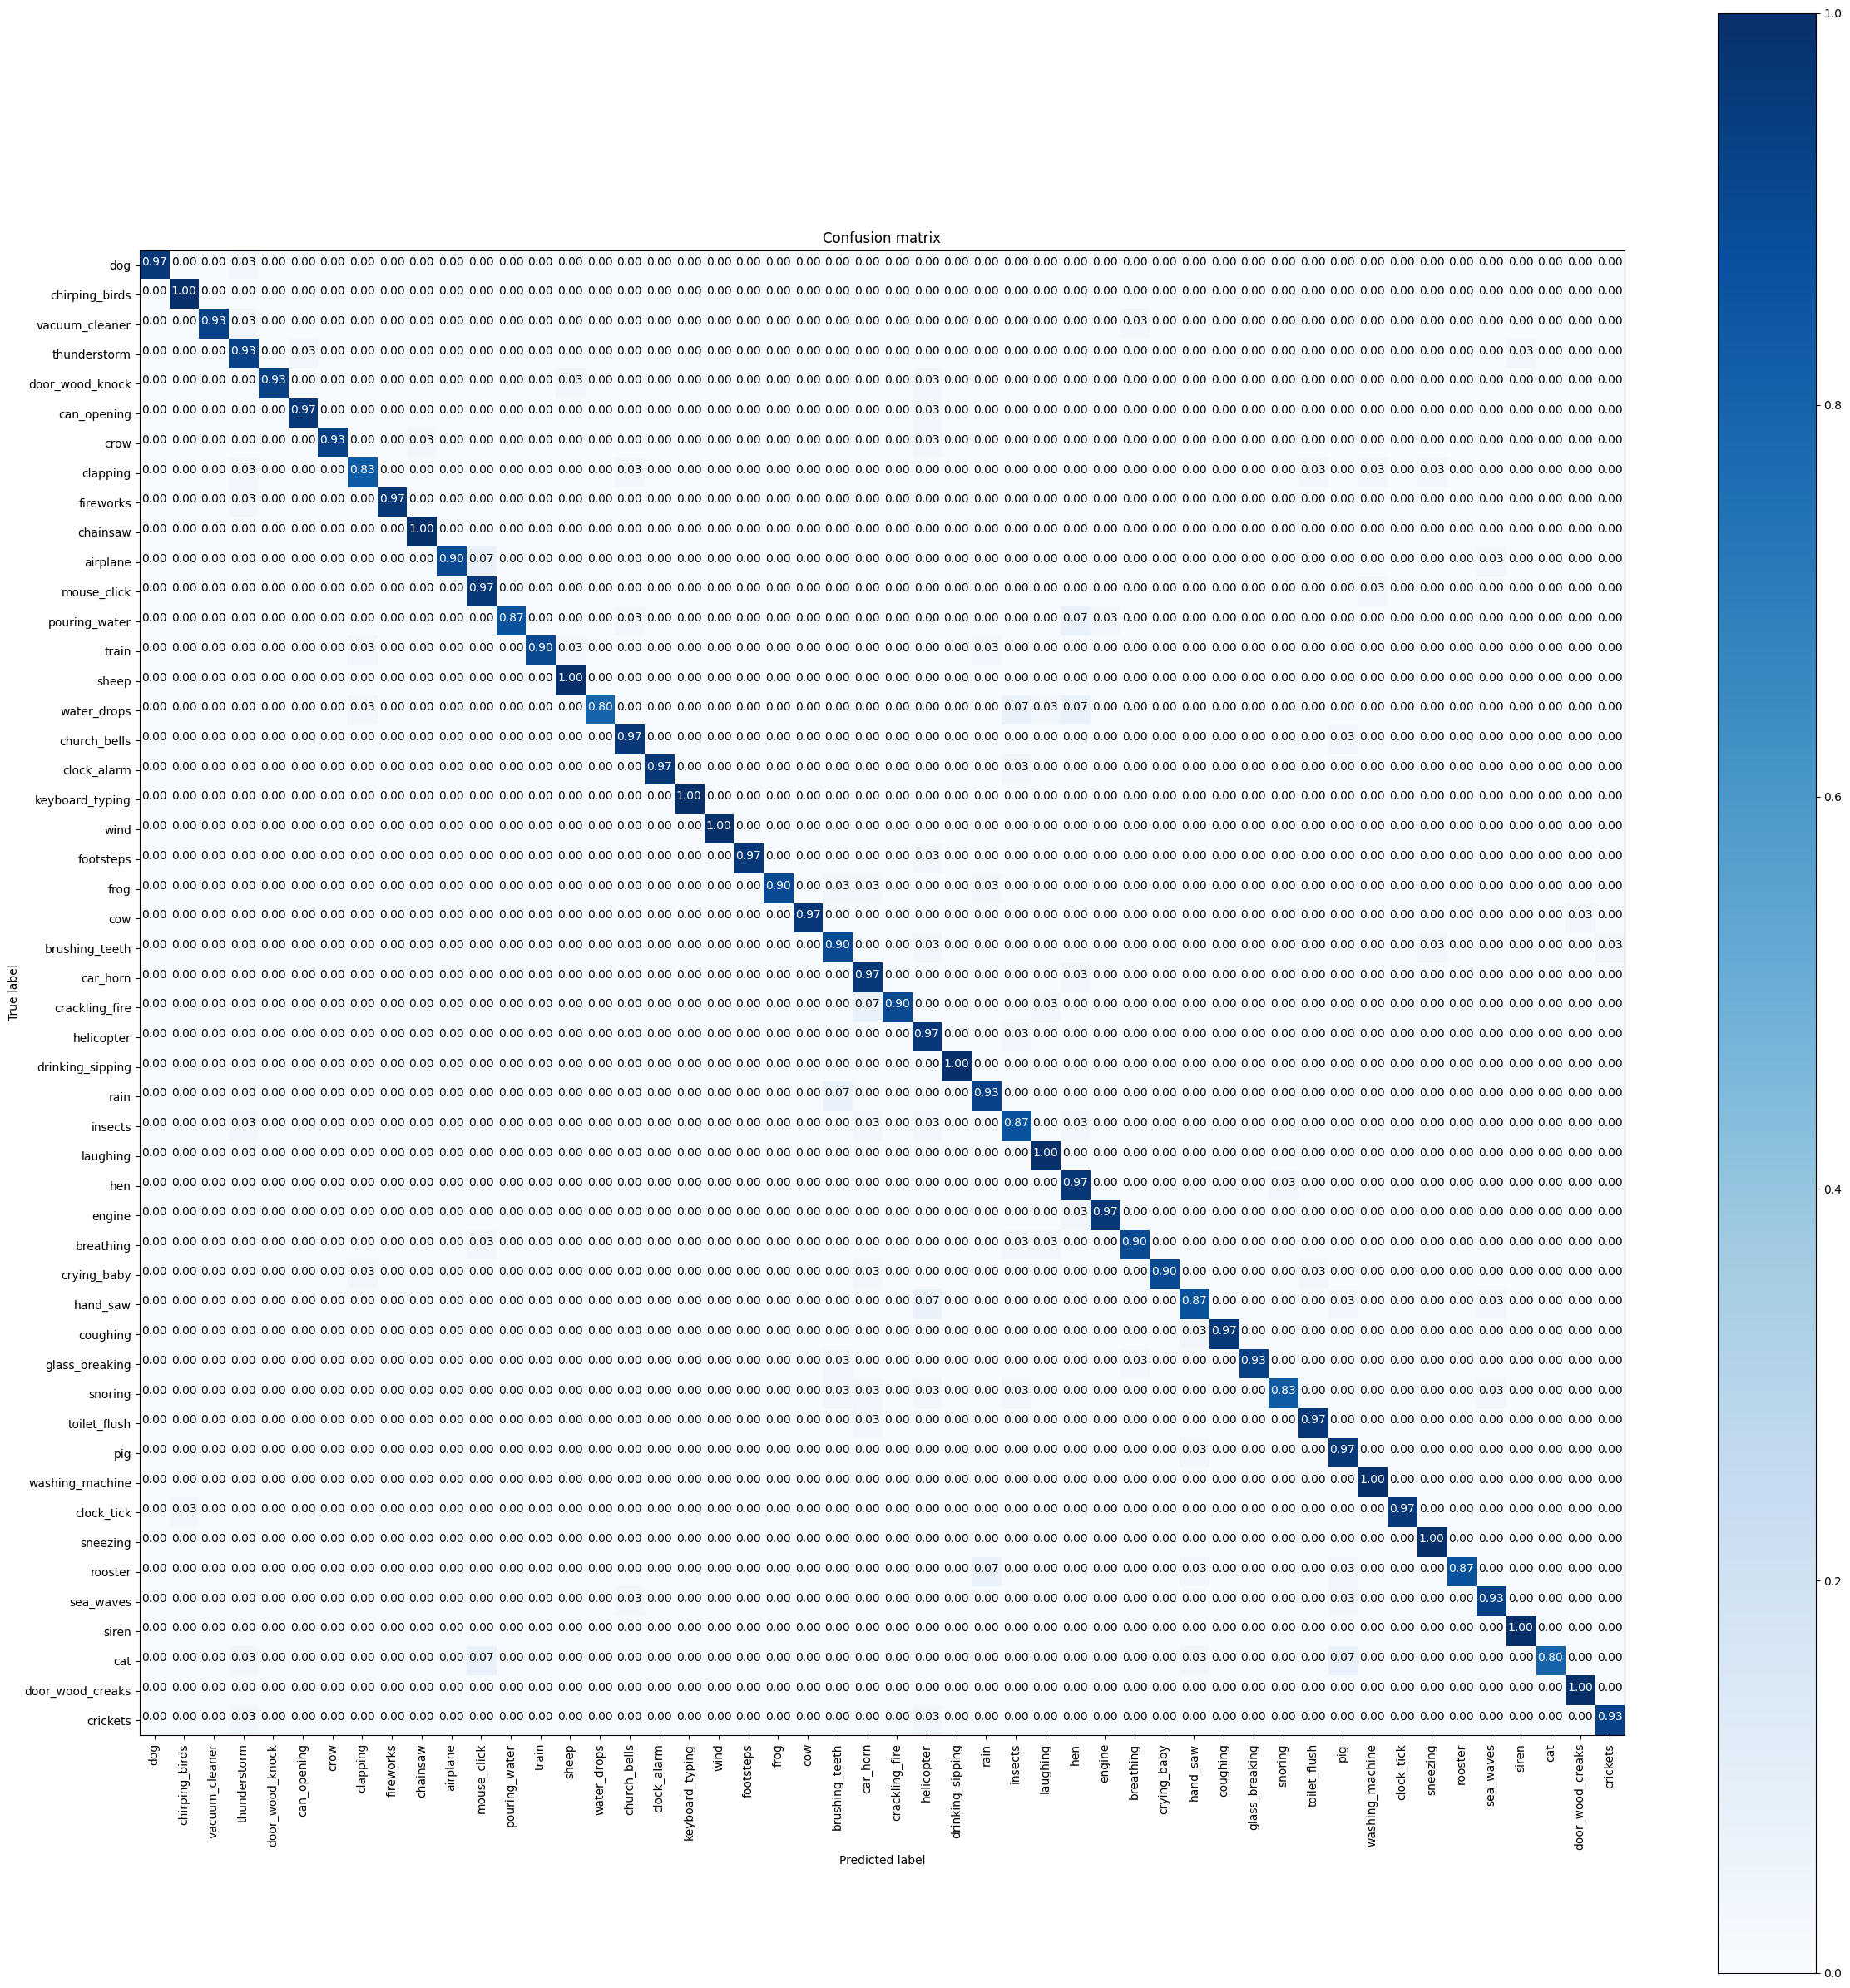

In [135]:
class_names = np.asarray(class_pd.classes)
plot_confusion_matrix(cm, class_names) #y_testのconfusion matrix

In [ ]:
#↓ここから下はまだ試していないです。

## Predict One

In [147]:
def predict_one(file_path, k, threshold=0.25):
    expected_shape = (1, freq, time, 1)
    x, fs = librosa.load(file_path, sr=44100)
    show_wave(x)
    show_melsp(calculate_melsp(x), fs)
    if (freq-1)*time < x.size < freq*time: 
        melsp_x = calculate_melsp(x)
    else:
        x_new = np.zeros(freq*time-1)
        x_new.flat[:freq*time-1] = x
        melsp_x = calculate_melsp(x_new)
        print("Signal reshaped", x_new.shape)
        show_wave(x_new)
        show_melsp(melsp_x, fs)

    melsp_x = melsp_x.reshape(expected_shape)
    preds = model.predict(melsp_x).flatten()
    sorted_array = np.argsort(preds)[::-1]
    top_k = sorted_array[:k]
    classes = []
    for i in top_k:
        classes.append(class_pd.classes[class_pd[class_pd.labels == i].index[0]])
    if preds[top_k[0]] < threshold:
        print("Not sure about result...", preds[top_k[0]])
    else:
        print(classes)
    return ipd.Audio(x, rate=fs)


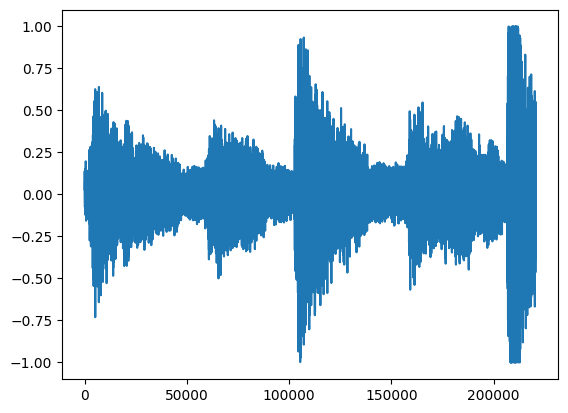

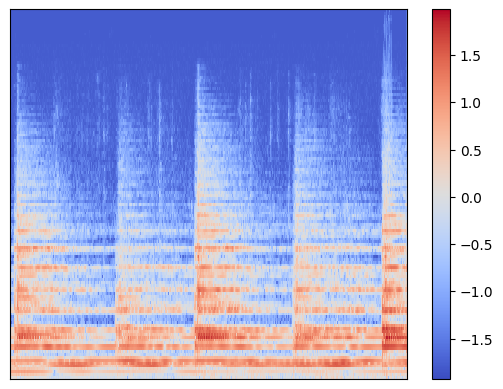

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step
['church_bells', 'cow', 'cat']


In [150]:
file_path = 'ESC-50-master/audio/1-13571-A-46.wav'
predict_one(file_path, 3, 0.5)